#       SEVERSTAL STEEL DEFECT DETECTION

## PROJECT OVERVIEW :

<font size=4>Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, we identify the defects present in steel sheets.

Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.
</font>

## OBJECTIVE :

<font size=4>Severstal uses images from high frequency cameras to power a defect detection algorithm.From that data, we predict the locations of the defect site and type of the defects present in them. This results in efficient production and maintaining manufacturing standards high.
</font>

## DATA ACQUISITION :

<font size=4>Data is avaible in a kaggle competion posted by Severstal.
    
  https://www.kaggle.com/c/severstal-steel-defect-detection
</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MODULES


In [2]:
import pandas as pd
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import prettytable
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from tensorflow.keras.models import load_model
import cv2
import keras

Using TensorFlow backend.


In [3]:
root_path = '/content/drive/MyDrive/Case_Study_2/train_images/'

## DATA OVERVIEW :

In [ ]:
# Loading the names of the train and test images


Train_image_names = []
for i in os.listdir('/content/drive/MyDrive/Case_Study_2/train_images'):
    Train_image_names.append(i)

Test_image_names = []
for i in os.listdir('/content/drive/MyDrive/Case_Study_2/test_images'):
    Test_image_names.append(i)

In [ ]:
print("Number of train images = " + str(len(Train_image_names)))
print("Number of test images = " + str(len(Test_image_names)))

Number of train images = 12568
Number of test images = 5506


In [ ]:
# The defects present in the images are given in Run-Length-Encoded(RLE) pixel values in train.csv file

Encoded_pixels_train = pd.read_csv('/content/drive/MyDrive/Case_Study_2/train.csv')
Encoded_pixels_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
print("Number of images with atleast one defect = " + str(len((Encoded_pixels_train['ImageId'].unique()))))

Number of images with atleast one defect = 6666


> <font size=3>The Number of images with Defects = 6666.
</font>


> <font size=3>The Number of images without Defects = 12568-6666 = 5902.</font>

<font size=4>Forming Train Dataframe showing Encoded pixel values and the presence of defects in each image.</font>

In [ ]:
dataframe_train = pd.DataFrame(Train_image_names,columns=['Id'])
dataframe_train['Class1'] = np.NaN
dataframe_train['Class2'] = np.NaN
dataframe_train['Class3'] = np.NaN
dataframe_train['Class4'] = np.NaN
dataframe_train['RLE1'] = np.NaN
dataframe_train['RLE2'] = np.NaN
dataframe_train['RLE3'] = np.NaN
dataframe_train['RLE4'] = np.NaN

# RLE Stands for Run length Encoding 

In [ ]:
for i in range(len(Encoded_pixels_train)):
    
    if Encoded_pixels_train['ClassId'][i] == 1:
        dataframe_train.loc[dataframe_train.Id == Encoded_pixels_train['ImageId'][i], ['Class1','RLE1']] = 1,Encoded_pixels_train['EncodedPixels'][i]
    
    elif Encoded_pixels_train['ClassId'][i] == 2:
        dataframe_train.loc[dataframe_train.Id == Encoded_pixels_train['ImageId'][i], ['Class2','RLE2']] = 1,Encoded_pixels_train['EncodedPixels'][i]
    
    elif Encoded_pixels_train['ClassId'][i] == 3:
        dataframe_train.loc[dataframe_train.Id == Encoded_pixels_train['ImageId'][i], ['Class3','RLE3']] = 1,Encoded_pixels_train['EncodedPixels'][i]
    
    elif Encoded_pixels_train['ClassId'][i] == 4:
        dataframe_train.loc[dataframe_train.Id == Encoded_pixels_train['ImageId'][i], ['Class4','RLE4']] = 1,Encoded_pixels_train['EncodedPixels'][i]

dataframe_train = dataframe_train.fillna(0)
dataframe_train['RLE1'] = dataframe_train['RLE1'].replace(0,"")
dataframe_train['RLE2'] = dataframe_train['RLE2'].replace(0,"")
dataframe_train['RLE3'] = dataframe_train['RLE3'].replace(0,"")
dataframe_train['RLE4'] = dataframe_train['RLE4'].replace(0,"")

dataframe_train['Class1'] = dataframe_train['Class1'].astype(int)
dataframe_train['Class2'] = dataframe_train['Class2'].astype(int)
dataframe_train['Class3'] = dataframe_train['Class3'].astype(int)
dataframe_train['Class4'] = dataframe_train['Class4'].astype(int)

dataframe_train.head()


,Id,Class1,Class2,Class3,Class4,RLE1,RLE2,RLE3,RLE4
0,ebd992f54.jpg,0,0,0,0,,,,
1,ea5c8ec19.jpg,0,0,1,0,,,156196 17 156445 50 156693 85 156942 119 15719...,
2,eb38788df.jpg,0,0,0,0,,,,
3,eb4225311.jpg,0,0,1,0,,,303400 7 303654 15 303908 19 304163 19 304187 ...,
4,eadff74bc.jpg,0,0,1,0,,,94198 2 94450 6 94703 9 94955 13 95207 17 9546...,


<font size=4>'1' indicates the presence of defect and '0' indicates absence.

RLE indicates the location of the defects.
</font>

## EXPLORATORY DATA ANALYSIS :

<font size = 4.5 color='blue'> 1. Checking size of train and test images. </font>

In [ ]:
size_list_train= []
for i in tqdm(os.listdir('/content/drive/MyDrive/Case_Study_2/train_images')):
    
    img = Image.open('/content/drive/MyDrive/Case_Study_2/train_images/'+i)
    size = img.size
    if size not in size_list_train:
        size_list_train.append(size)
size_list_train

100%|██████████| 12568/12568 [47:51<00:00,  4.38it/s]


[(1600, 256)]

In [ ]:
size_list_test= []
for i in tqdm(os.listdir('/content/drive/MyDrive/Case_Study_2/test_images')):
    
    img = Image.open('/content/drive/MyDrive/Case_Study_2/test_images/'+i)
    size = img.size
    if size not in size_list_test:
        size_list_test.append(size)
size_list_test

100%|██████████| 5506/5506 [22:20<00:00,  4.11it/s]


[(1600, 256)]

### Observation:
<font size = 4> All the train and test images have same size (1600,256). </font>

<font size = 4.5 color='blue'> 2. Checking Number of images per each class and Number of Images with No_defect/Single_defect/Multiple_defects.</font>

Text(0.5, 1.0, 'Number of images for each defect class')

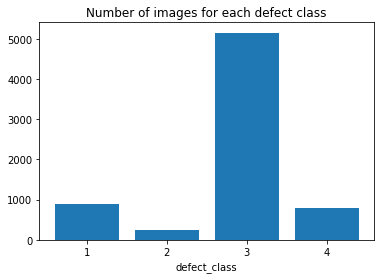

In [ ]:
x = ['1','2','3','4']
y = [dataframe_train['Class1'].sum(),dataframe_train['Class2'].sum(),dataframe_train['Class3'].sum(),dataframe_train['Class4'].sum()]
plt.bar(x,y)
plt.xlabel('defect_class')
plt.title('Number of images for each defect class')

Text(0.5, 1.0, 'Number of Images with No_defect/single_defect/multiple_defects')

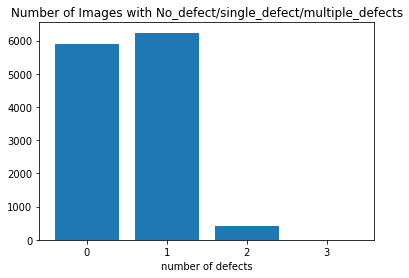

In [ ]:
a = (dataframe_train['Class1']+dataframe_train['Class2']+dataframe_train['Class3']+dataframe_train['Class4']).value_counts()
x = ['0','1','2','3']
y = [a[0],a[1],a[2],a[3]]
plt.bar(x,y)
plt.xlabel('number of defects')
plt.title('Number of Images with No_defect/single_defect/multiple_defects')

### Observation:



<font size = 4> 

1. There is a clear imbalance in the data.


2. Class3 and Class2 are majority and minority classes respectively.


3. Number of images with no defects are pretty high (5902).
    

4. Most of the images have single defect, number of images with two defects are less than 500, and the number of images with 3 defects =2 which is very low.
</font>

<font size = 4.5 color='blue'> 3. Visualization using Masked images formed with Run-Length-Encoding Values</font>

In [18]:
# function to covert Run-Length-Encoded Values to masks
# reference: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(1600,256)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T
    

<font size = 4.5> Images with Class_1 Defect</font>

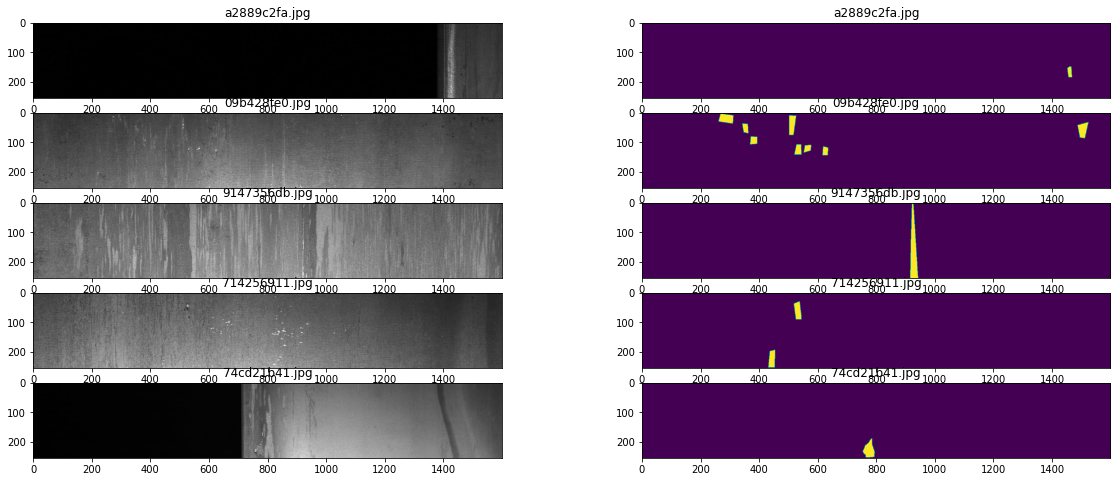

In [ ]:
a = dataframe_train[dataframe_train['Class1']==1][['Id','RLE1']]

plt.figure(figsize=(20,8))
sample = a.sample(5)
j = 0
for i in range(len(sample)):

    plt.subplot(5,2,i+1+j).set_title(sample['Id'].values[i])
    img = Image.open(root_path + sample['Id'].values[i])
    plt.imshow(img)
    plt.subplot(5,2,i+2+j).set_title(sample['Id'].values[i])
    plt.imshow(rle2mask(sample['RLE1'].values[i]))
    j = j +1


<font size = 4.5> Images with Class_2 Defect</font>

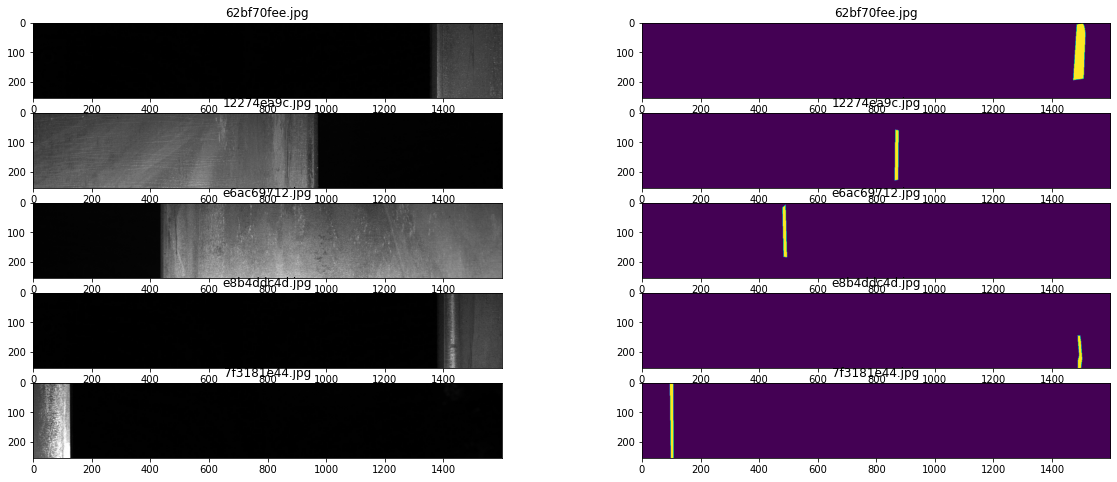

In [ ]:
a = dataframe_train[dataframe_train['Class2']==1][['Id','RLE2']]
plt.figure(figsize=(20,8))
sample = a.sample(5)
j = 0
for i in range(len(sample)):

    plt.subplot(5,2,i+1+j).set_title(sample['Id'].values[i])
    img = Image.open(root_path + sample['Id'].values[i])
    plt.imshow(img)
    plt.subplot(5,2,i+2+j).set_title(sample['Id'].values[i])
    plt.imshow(rle2mask(sample['RLE2'].values[i]))
    j = j +1

<font size = 4.5> Images with Class_3 Defect</font>

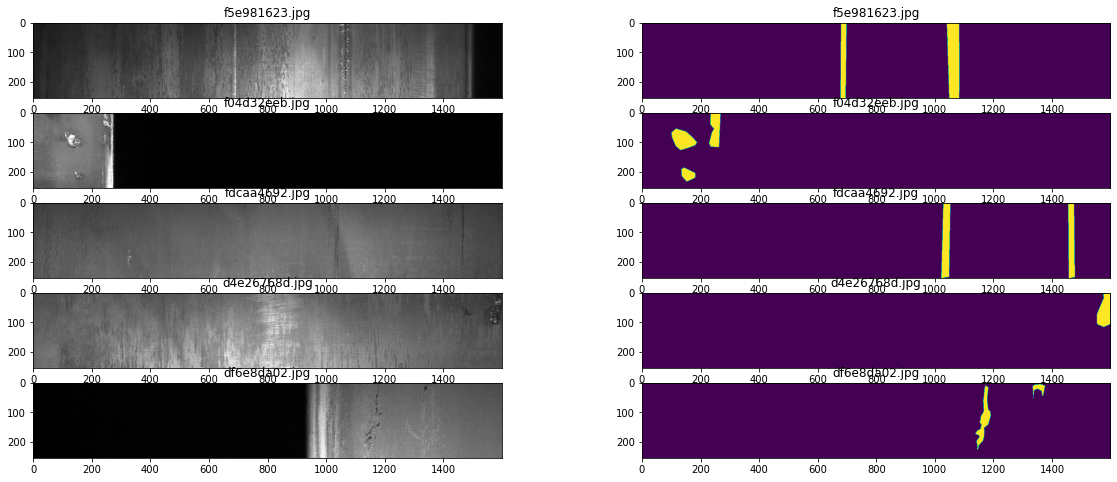

In [ ]:
a = dataframe_train[dataframe_train['Class3']==1][['Id','RLE3']]
plt.figure(figsize=(20,8))
sample = a.sample(5)
j = 0
for i in range(len(sample)):

    plt.subplot(5,2,i+1+j).set_title(sample['Id'].values[i])
    img = Image.open(root_path + sample['Id'].values[i])
    plt.imshow(img)
    plt.subplot(5,2,i+2+j).set_title(sample['Id'].values[i])
    plt.imshow(rle2mask(sample['RLE3'].values[i]))
    j = j +1

<font size = 4.5> Images with Class_4 Defect</font>

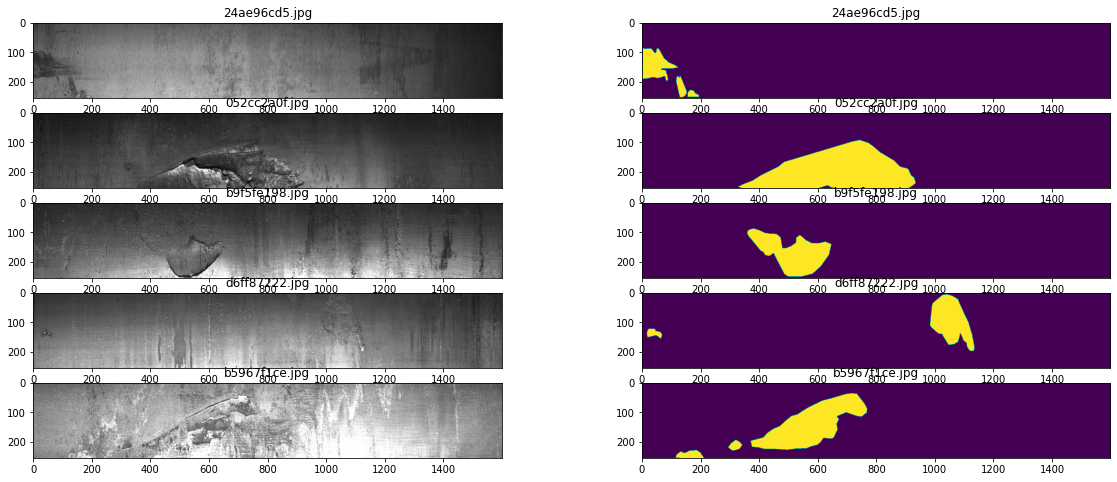

In [ ]:
a = dataframe_train[dataframe_train['Class4']==1][['Id','RLE4']]
plt.figure(figsize=(20,8))
sample = a.sample(5)
j = 0
for i in range(len(sample)):

    plt.subplot(5,2,i+1+j).set_title(sample['Id'].values[i])
    img = Image.open(root_path + sample['Id'].values[i])
    plt.imshow(img)
    plt.subplot(5,2,i+2+j).set_title(sample['Id'].values[i])
    plt.imshow(rle2mask(sample['RLE4'].values[i]))
    j = j +1

## Observation:

1. Class 4 and class 3 defects looks worst among all the defects.

2. Class1 defects are not spread widely on the sheet. They are more like point defects.



## Observations From EDA:

1. All the train and test images have same size, resizing images is not required.


2. The data is highly imbalanced. class2 defect images are very less. Performing Data Augmentation might be helpful.


3. 5902 images have no defect ie. almost half of the images.


4. Number of Images with Class3 > Class1 > Class4 > Class2. 


5. Images with multiple defects are less. (images with 2 defects are < 300, images with 3 defects = 2).


In [ ]:
# some images have more than 2 labels, in that case we give class_label of the class with less points, 
# This makes strarified sampling possible. 


labels = []

for i in range(len(dataframe_train)):
    
    if dataframe_train['Class2'].values[i] == 1:
        labels.append(2)
    
    elif dataframe_train['Class4'].values[i] == 1:
        labels.append(4)
    
    elif dataframe_train['Class1'].values[i] == 1:
        labels.append(1)
    
    elif dataframe_train['Class3'].values[i] == 1:
        labels.append(3)
    
    else:
        labels.append(0)

dataframe_train['Class_Label'] = labels

In [ ]:
# defect_present column indicates the presence of any defect in the images .

defect_present = []

for i in range(len(dataframe_train)):
    
    if dataframe_train['Class_Label'].values[i] != 0:
        defect_present.append(1)

    else:
        defect_present.append(0)

dataframe_train['defect_present'] = defect_present

In [ ]:
dataframe_train.to_csv("/content/drive/MyDrive/Case_Study_2/dataframe_train",index=False)

In [4]:
dataframe_train = pd.read_csv('/content/drive/MyDrive/Case_Study_2/dataframe_train')

In [5]:
dataframe_train.head()

,Id,Class1,Class2,Class3,Class4,RLE1,RLE2,RLE3,RLE4,Class_Label,defect_present
0,ebd992f54.jpg,0,0,0,0,NaN,NaN,NaN,NaN,0,0
1,ea5c8ec19.jpg,0,0,1,0,NaN,NaN,156196 17 156445 50 156693 85 156942 119 15719...,NaN,3,1
2,eb38788df.jpg,0,0,0,0,NaN,NaN,NaN,NaN,0,0
3,eb4225311.jpg,0,0,1,0,NaN,NaN,303400 7 303654 15 303908 19 304163 19 304187 ...,NaN,3,1
4,eadff74bc.jpg,0,0,1,0,NaN,NaN,94198 2 94450 6 94703 9 94955 13 95207 17 9546...,NaN,3,1


## Train Test Split

In [6]:
X_tr, X_te = train_test_split(dataframe_train, test_size = 0.1, stratify = dataframe_train['Class_Label'],random_state=42)
X_tr, X_cv = train_test_split(X_tr, test_size = 0.11, stratify = X_tr['Class_Label'],random_state=42)


x = PrettyTable(["Dataset", "Shape"])
x.add_row(["X_tr",str(X_tr.shape)])
x.add_row(["X_cv",str(X_cv.shape)])
x.add_row(["X_te",str(X_te.shape)])
print(x)

+---------+-------------+
| Dataset |    Shape    |
+---------+-------------+
|   X_tr  | (10066, 11) |
|   X_cv  |  (1245, 11) |
|   X_te  |  (1257, 11) |
+---------+-------------+


# **MODEL** :



## 1. BINARY CLASSIFICATION MODEL :
(First we train a binary classification model to check the presence of defect in the image.)

><font size="4" color='blue'>Data Pipeline for Binary Classification Model</font>


In [ ]:
X_tr_1 = X_tr[['Id','defect_present']].astype(str)
X_cv_1 = X_cv[['Id','defect_present']].astype(str)
X_te_1 = X_te[['Id','defect_present']].astype(str)

X_tr_1.head()

,Id,defect_present
9097,343bec579.jpg,0
5610,8f8104c9c.jpg,1
3509,b8b4d7133.jpg,1
9944,46892b360.jpg,0
11611,16b00d4ef.jpg,0


In [ ]:
# Image Augmentaion using tf.ImageDataGenerator

train_datagen_Binary = ImageDataGenerator(rescale=1./255,rotation_range = 5rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)

test_datagen_Binary = ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagen_1 = train_datagen_Binary.flow_from_dataframe(dataframe = X_tr_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

cv_datagen_1 = test_datagen_Binary.flow_from_dataframe(dataframe = X_cv_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

Found 10066 validated image filenames belonging to 2 classes.
Found 1245 validated image filenames belonging to 2 classes.


><font size="4" color='blue'>1.1 VGG-16 MODEL
</font>


In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False,input_shape=(299, 299, 3))

x = vgg_model.output

# Conv Block
x= Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2),padding='same', strides=(1, 1))(x)

x = Flatten()(x)

# Dense Block 1 
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 2
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)

# Output
outputlayer = Dense(1, activation='sigmoid')(x)

binary_model_vgg16 = Model(inputs = vgg_model.input, outputs = outputlayer)

In [ ]:
binary_model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0   

><font size="4" color='blue'>METRICS:</font>


In [ ]:
# Reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_1 = precision(y_true, y_pred)
    recall_1 = recall(y_true, y_pred)
    return 2*((precision_1*recall_1)/(precision_1+recall_1+K.epsilon()))

****
><font size="4" color='blue'>CALLBACKS_VGG16</font>


In [ ]:

model_filepath_Binary_model_vgg16 = '/content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_vgg16.h5'
model_checkpoint_Binary_model_vgg16 = ModelCheckpoint(filepath = model_filepath_Binary_model_vgg16, monitor = 'val_f1_score',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir_Binary_model_vgg16 = '/content/drive/MyDrive/Case_Study_2/logs_binary_model_vgg16/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_Binary_model_vgg16 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir_Binary_model_vgg16,histogram_freq = 0)

In [ ]:

binary_model_vgg16.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])


In [ ]:
history_1_Binary_model = binary_model_vgg16.fit_generator(train_datagen_1, validation_data = cv_datagen_1, epochs = 25, verbose=1, callbacks = [model_checkpoint_Binary_model_vgg16,tensorboard_callback_Binary_model_vgg16])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
630/630 [==============================] - 7613s 12s/step - loss: 0.6536 - accuracy: 0.6510 - precision: 0.6740 - recall: 0.6563 - f1_score: 0.6426 - val_loss: 536.0147 - val_accuracy: 0.4699 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_vgg16.h5
Epoch 2/25
630/630 [==============================] - 351s 557ms/step - loss: 0.5700 - accuracy: 0.6986 - precision: 0.6991 - recall: 0.7547 - f1_score: 0.7121 - val_loss: 69.0049 - val_accuracy: 0.6145 - val_precision: 0.8687 - val_recall: 0.3015 - val_f1_score: 0.4288

Epoch 00002: val_f1_score improved from 0.00000 to 0.42882, saving model to /content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_vgg16.h5
Epoch 3/25
630/630 [==============================] - 347s 550ms/step - loss: 0.5600 - accuracy: 0.7130 - precision: 0.7092 - recall: 0.7897 - f1_score

In [ ]:
history_1_Binary_model.history

{'accuracy': [0.6726604700088501,
  0.7029604315757751,
  0.7108086347579956,
  0.7228293418884277,
  0.7197496294975281,
  0.72471684217453,
  0.7320683598518372,
  0.7331611514091492,
  0.7375322580337524,
  0.7308762073516846,
  0.7380290031433105,
  0.7378303408622742,
  0.739022433757782,
  0.7422014474868774,
  0.7419034242630005,
  0.7459765672683716,
  0.7453804612159729,
  0.7440890073776245,
  0.7451817989349365,
  0.7499503493309021,
  0.749453604221344,
  0.7507450580596924,
  0.759090006351471,
  0.753824770450592,
  0.7643552422523499],
 'f1_score': [0.6889404654502869,
  0.7189642190933228,
  0.7302154898643494,
  0.7418925762176514,
  0.7393916249275208,
  0.7462968826293945,
  0.7555887699127197,
  0.754696786403656,
  0.760208010673523,
  0.7549644112586975,
  0.7605555653572083,
  0.7530152201652527,
  0.7576620578765869,
  0.7629841566085815,
  0.7634217143058777,
  0.766768753528595,
  0.765247642993927,
  0.7620022296905518,
  0.7629198431968689,
  0.7707251906394

**OBSERVATION:**

1. The best accuracy using vgg16 architecture with imagenet weights is 73.2% which is quite low. So, We use architectures like InceptionV3 and Xception to check whether we can improve the metrics.  

><font size="4" color='blue'>1.2 InceptionV3 Model:
</font>


In [ ]:
# datagenerator for InceptionV3 model

train_datagen_2 = train_datagen_Binary.flow_from_dataframe(dataframe = X_tr_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

cv_datagen_2 = test_datagen_Binary.flow_from_dataframe(dataframe = X_cv_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

Found 10066 validated image filenames belonging to 2 classes.
Found 1245 validated image filenames belonging to 2 classes.


In [ ]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(299, 299, 3))

x = InceptionV3_model.output

x = GlobalAveragePooling2D()(x)

# Dense Block 1 

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense Block 2

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Dense Block 3

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output
outputlayer = Dense(1, activation='sigmoid')(x)


binary_model_InceptionV3 = Model(inputs = InceptionV3_model.input, outputs = outputlayer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
binary_model_InceptionV3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 149, 149, 32) 96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

><font size="4" color='blue'>CALLBACKS_InceptionV3</font>


In [ ]:
model_filepath_InceptionV3 = '/content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_InceptionV3.h5'
model_checkpoint_InceptionV3 = ModelCheckpoint(filepath = model_filepath_InceptionV3, monitor = 'val_f1_score',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir_InceptionV3 = '/content/drive/MyDrive/Case_Study_2/logs_binary_model_InceptionV3/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_InceptionV3 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir_InceptionV3,histogram_freq = 0)

In [ ]:
binary_model_InceptionV3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

In [ ]:
history_1_Binary_model_InceptionV3 = binary_model_InceptionV3.fit_generator(train_datagen_2, validation_data = cv_datagen_2, epochs = 25, verbose=1, callbacks = [model_checkpoint_InceptionV3,tensorboard_callback_InceptionV3])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
630/630 [==============================] - 341s 525ms/step - loss: 0.7593 - accuracy: 0.6182 - precision: 0.6359 - recall: 0.6741 - f1_score: 0.6417 - val_loss: 0.8750 - val_accuracy: 0.5213 - val_precision: 0.5932 - val_recall: 0.1351 - val_f1_score: 0.2098

Epoch 00001: val_f1_score improved from -inf to 0.20980, saving model to /content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_InceptionV3.h5
Epoch 2/25
630/630 [==============================] - 324s 514ms/step - loss: 0.4788 - accuracy: 0.7644 - precision: 0.7842 - recall: 0.7826 - f1_score: 0.7677 - val_loss: 0.9752 - val_accuracy: 0.4892 - val_precision: 0.3077 - val_recall: 0.0384 - val_f1_score: 0.0677

Epoch 00002: val_f1_score did not improve from 0.20980
Epoch 3/25
630/630 [==============================] - 322s 511ms/step - loss: 0.4340 - accuracy: 0.7992 - precision: 0.8074 - recall: 0.8386 - f1_score: 0.8069 - val_loss: 0.5488 - val_accuracy: 0.7277 - val_precision: 0.9197 - val_recall: 0.5400 - val

In [ ]:
history_1_Binary_model_InceptionV3.history

{'accuracy': [0.6797139048576355,
  0.7877011895179749,
  0.7988277077674866,
  0.7792568802833557,
  0.7921716570854187,
  0.8176038265228271,
  0.8379694223403931,
  0.8611166477203369,
  0.8631035089492798,
  0.8717464804649353,
  0.8665805459022522,
  0.8819789290428162,
  0.8835684657096863,
  0.8880389332771301,
  0.8901251554489136,
  0.8884363174438477,
  0.8905225396156311,
  0.8981720805168152,
  0.9009537100791931,
  0.9093979597091675,
  0.907609760761261,
  0.9101927280426025,
  0.9089012742042542,
  0.915557324886322,
  0.9199284911155701],
 'f1_score': [0.698322057723999,
  0.7934405207633972,
  0.8064827919006348,
  0.7894537448883057,
  0.8023892641067505,
  0.8223153948783875,
  0.842140793800354,
  0.8660958409309387,
  0.8658400774002075,
  0.8766160607337952,
  0.870763897895813,
  0.8837182521820068,
  0.8859969973564148,
  0.891004204750061,
  0.8936465382575989,
  0.8906942009925842,
  0.8928384184837341,
  0.9000692963600159,
  0.9039615988731384,
  0.910407841

><font size="4" color='blue'>1.3 Xception Model:
</font>


In [ ]:
# datagenerator for InceptionV3 model

train_datagen_3 = train_datagen_Binary.flow_from_dataframe(dataframe = X_tr_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

cv_datagen_3 = test_datagen_Binary.flow_from_dataframe(dataframe = X_cv_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

Found 10066 validated image filenames belonging to 2 classes.
Found 1245 validated image filenames belonging to 2 classes.


In [ ]:
Xception_model =  Xception(weights='imagenet', include_top=False,input_shape=(299,299, 3))

x = Xception_model.output

x = GlobalAveragePooling2D()(x)

# Dense Block 1 

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense Block 2

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 3

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 4

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)


# Output
outputlayer = Dense(1, activation='sigmoid')(x)


binary_model_Xception = Model(inputs = Xception_model.input, outputs = outputlayer)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
binary_model_Xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

><font size="4" color='blue'>CALLBACKS_Xception</font>


In [ ]:
model_filepath_Xception = '/content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_Xception.h5'
model_checkpoint_Xception = ModelCheckpoint(filepath = model_filepath_Xception, monitor = 'val_f1_score',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir_Xception = '/content/drive/MyDrive/Case_Study_2/logs_binary_model_Xception/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_Xception = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir_Xception,histogram_freq = 0)

In [ ]:
binary_model_Xception.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

In [ ]:
history_1_Binary_model_Xception = binary_model_Xception.fit_generator(train_datagen_3, validation_data = cv_datagen_3, epochs = 25, verbose=1, callbacks = [model_checkpoint_Xception,tensorboard_callback_Xception])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
630/630 [==============================] - 374s 582ms/step - loss: 0.6349 - accuracy: 0.6772 - precision: 0.6974 - recall: 0.7353 - f1_score: 0.6980 - val_loss: 0.4079 - val_accuracy: 0.8329 - val_precision: 0.8575 - val_recall: 0.8242 - val_f1_score: 0.8316

Epoch 00001: val_f1_score improved from -inf to 0.83159, saving model to /content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_Xception.h5
Epoch 2/25
630/630 [==============================] - 364s 577ms/step - loss: 0.4031 - accuracy: 0.8204 - precision: 0.8421 - recall: 0.8338 - f1_score: 0.8249 - val_loss: 0.7273 - val_accuracy: 0.5855 - val_precision: 0.8190 - val_recall: 0.2557 - val_f1_score: 0.3746

Epoch 00002: val_f1_score did not improve from 0.83159
Epoch 3/25
630/630 [==============================] - 361s 573ms/step - loss: 0.3273 - accuracy: 0.8558 - precision: 0.8621 - recall: 0.8831 - f1_score: 0.8572 - val_loss: 0.3907 - val_accuracy: 0.8169 - val_precision: 0.9644 - val_recall: 0.6851 - val_f1

In [ ]:
history_1_Binary_model_Xception.history

{'accuracy': [0.7105106115341187,
  0.8291277289390564,
  0.8640969395637512,
  0.8647923469543457,
  0.8787999153137207,
  0.8854559659957886,
  0.8889330625534058,
  0.8558513522148132,
  0.888634979724884,
  0.899066150188446,
  0.9006556868553162,
  0.9041327238082886,
  0.9034373164176941,
  0.9046294689178467,
  0.9081065058708191,
  0.9088019132614136,
  0.9165507555007935,
  0.9225113987922668,
  0.9211205840110779,
  0.9168487787246704,
  0.9215179681777954,
  0.922710120677948,
  0.9286707639694214,
  0.9286707639694214,
  0.932346522808075],
 'f1_score': [0.7243574857711792,
  0.8323111534118652,
  0.8665761947631836,
  0.8663104176521301,
  0.8824298977851868,
  0.8863037824630737,
  0.8911385536193848,
  0.8594350814819336,
  0.8913450241088867,
  0.9007083773612976,
  0.9033117890357971,
  0.9056715369224548,
  0.9036259651184082,
  0.9037362933158875,
  0.9084176421165466,
  0.9099835157394409,
  0.9178739190101624,
  0.9246799945831299,
  0.9224187731742859,
  0.9171548

In [ ]:
binary_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Binary_Xception_model_weights_after25epochs.h5')

In [ ]:
binary_model_Xception.load_weights('/content/drive/MyDrive/Case_Study_2/Binary_Xception_model_weights_after25epochs.h5')

In [ ]:
history_2_Binary_model_Xception = binary_model_Xception.fit_generator(train_datagen_3, validation_data = cv_datagen_3, epochs = 25, verbose=1, callbacks = [model_checkpoint_Xception,tensorboard_callback_Xception])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
630/630 [==============================] - 3965s 6s/step - loss: 0.1810 - accuracy: 0.9308 - precision: 0.9361 - recall: 0.9330 - f1_score: 0.9300 - val_loss: 0.3318 - val_accuracy: 0.8755 - val_precision: 0.9419 - val_recall: 0.8184 - val_f1_score: 0.8693

Epoch 00001: val_f1_score improved from -inf to 0.86927, saving model to /content/drive/MyDrive/Case_Study_2/Binary_models/Binary_model_Xception.h5
Epoch 2/25
630/630 [==============================] - 390s 618ms/step - loss: 0.1722 - accuracy: 0.9344 - precision: 0.9382 - recall: 0.9403 - f1_score: 0.9348 - val_loss: 0.7246 - val_accuracy: 0.7606 - val_precision: 0.8582 - val_recall: 0.6501 - val_f1_score: 0.7229

Epoch 00002: val_f1_score did not improve from 0.86927
Epoch 3/25
630/630 [==============================] - 389s 617ms/step - loss: 0.1614 - accuracy: 0.9372 - precision: 0.9283 - recall: 0.9544 - f1_score: 0.9376 - val_loss: 0.2797 - val_accuracy: 0.9197 - val_precision: 0.8835 - val_recall: 0.9742 - val_f1_s

In [ ]:
binary_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Binary_Xception_model_weights_after50epochs.h5')

In [ ]:
history_2_Binary_model_Xception.history

{'accuracy': [0.9321478009223938,
  0.9361215829849243,
  0.9391019344329834,
  0.9403933882713318,
  0.9417842030525208,
  0.9419829249382019,
  0.9376117587089539,
  0.9446651935577393,
  0.9424796104431152,
  0.9451619386672974,
  0.9493343830108643,
  0.9391019344329834,
  0.9451619386672974,
  0.9445658922195435,
  0.9461553692817688,
  0.9318497776985168,
  0.9480429291725159,
  0.9505265355110168,
  0.9507251977920532,
  0.9542022943496704,
  0.9518179893493652,
  0.9550963640213013,
  0.9439697861671448,
  0.9523147344589233,
  0.9556924104690552],
 'f1_score': [0.9321410059928894,
  0.9370775818824768,
  0.9390587210655212,
  0.9382545948028564,
  0.9409170746803284,
  0.9407668113708496,
  0.9377515912055969,
  0.9449697136878967,
  0.9427168369293213,
  0.9449704885482788,
  0.9502859711647034,
  0.939177393913269,
  0.9436033368110657,
  0.9451021552085876,
  0.946080207824707,
  0.9325264096260071,
  0.9483676552772522,
  0.9489600658416748,
  0.9507616758346558,
  0.95377

In [ ]:
binary_model_Xception.load_weights('/content/drive/MyDrive/Case_Study_2/Binary_Xception_model_weights_after50epochs.h5')

In [ ]:
from keras import backend as K
K.set_value(binary_model_Xception.optimizer.learning_rate, 0.0001)

In [ ]:
history_3_Binary_model_Xception = binary_model_Xception.fit_generator(train_datagen_3, validation_data = cv_datagen_3, epochs = 10, verbose=1, callbacks = [model_checkpoint_Xception,tensorboard_callback_Xception])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
630/630 [==============================] - 389s 617ms/step - loss: 0.0905 - accuracy: 0.9647 - precision: 0.9718 - recall: 0.9620 - f1_score: 0.9650 - val_loss: 0.6141 - val_accuracy: 0.8546 - val_precision: 0.9655 - val_recall: 0.7490 - val_f1_score: 0.8348

Epoch 00001: val_f1_score did not improve from 0.92174
Epoch 2/10
630/630 [==============================] - 387s 613ms/step - loss: 0.0848 - accuracy: 0.9660 - precision: 0.9683 - recall: 0.9660 - f1_score: 0.9647 - val_loss: 0.6592 - val_accuracy: 0.8554 - val_precision: 0.9689 - val_recall: 0.7504 - val_f1_score: 0.8368

Epoch 00002: val_f1_score did not improve from 0.92174
Epoch 3/10
630/630 [==============================] - 387s 613ms/step - loss: 0.0828 - accuracy: 0.9675 - precision: 0.9708 - recall: 0.9678 - f1_score: 0.9670 - val_loss: 0.7023 - val_accuracy: 0.8562 - val_precision: 0.9694 - val_recall: 0.7552 - val_f1_score: 0.8394

Epoch 00003: val_f1_score did not improve from 0.92174
Epoch 4/10
630/630 [==

In [ ]:
binary_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Binary_Xception_model_weights_after75epochs.h5')

In [ ]:
history_3_Binary_model_Xception.history

{'accuracy': [0.9647327661514282,
  0.9660242199897766,
  0.9675143957138062,
  0.9671170115470886,
  0.9674150347709656,
  0.9708921313285828,
  0.9686071872711182,
  0.9711901545524597,
  0.9737731218338013,
  0.9718855619430542],
 'f1_score': [0.9649889469146729,
  0.964687168598175,
  0.9669970273971558,
  0.9661996960639954,
  0.9662865996360779,
  0.9706627130508423,
  0.9683117270469666,
  0.9695133566856384,
  0.9718890190124512,
  0.97227543592453],
 'loss': [0.09050697088241577,
  0.08477547764778137,
  0.08275534957647324,
  0.0820188894867897,
  0.0811898335814476,
  0.07222574949264526,
  0.07921152561903,
  0.0682053342461586,
  0.06894298642873764,
  0.0702228769659996],
 'precision': [0.9717972278594971,
  0.9682651162147522,
  0.9707575440406799,
  0.9681764841079712,
  0.9694850444793701,
  0.9742208123207092,
  0.9745698571205139,
  0.9744428396224976,
  0.9765906929969788,
  0.9755763411521912],
 'recall': [0.9619842767715454,
  0.9660494327545166,
  0.9678389430046

**OBSERVATIONS :**

1. For Binary Classification Task, Out of the three models (VGG16, InceptionV3, and Xception) we trained, Xception model performed better. Now let us visualize train and validation metrics using Xception model.


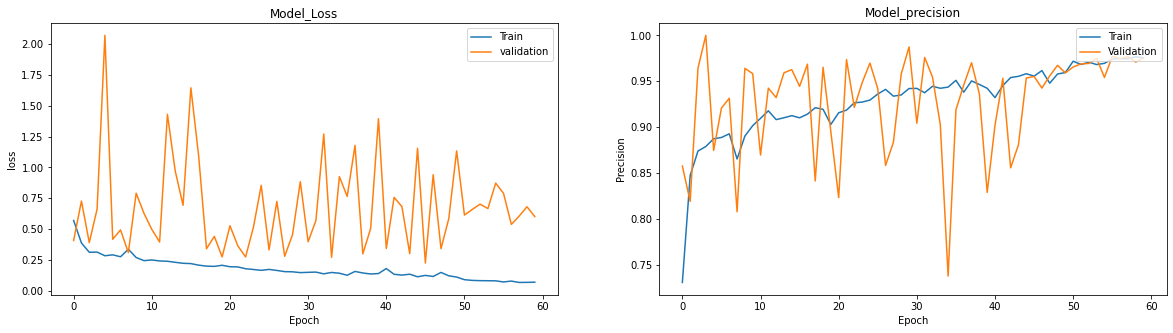

In [ ]:
# Plotting training & validation loss values (Xception Model)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_Binary_model_Xception.history['loss'] + history_2_Binary_model_Xception.history['loss'] + history_3_Binary_model_Xception.history['loss'])
plt.plot(history_1_Binary_model_Xception.history['val_loss'] + history_2_Binary_model_Xception.history['val_loss'] + history_3_Binary_model_Xception.history['val_loss'])
plt.title('Model_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_Binary_model_Xception.history['precision'] + history_2_Binary_model_Xception.history['precision'] + history_3_Binary_model_Xception.history['precision'])
plt.plot(history_1_Binary_model_Xception.history['val_precision'] + history_2_Binary_model_Xception.history['val_precision'] + history_3_Binary_model_Xception.history['val_precision'])
plt.title('Model_precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

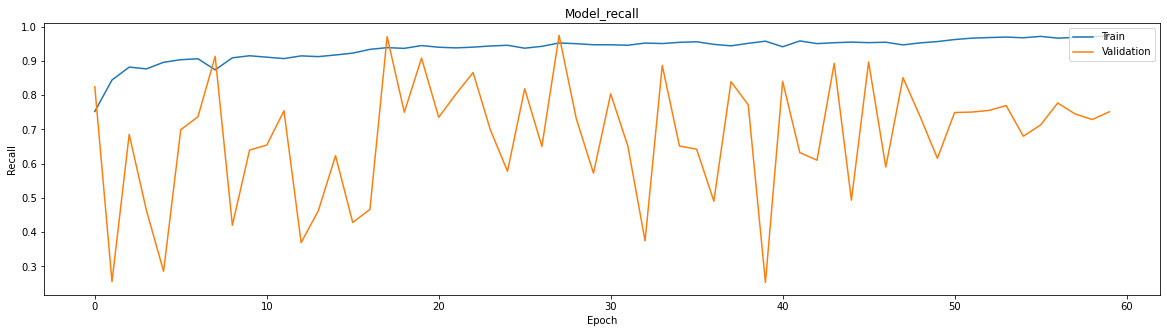

In [ ]:
# Plot training & validation Recall values
plt.figure(figsize=(20,5))
# plt.subplot(121)
plt.plot(history_1_Binary_model_Xception.history['recall'] + history_2_Binary_model_Xception.history['recall'] + history_3_Binary_model_Xception.history['recall'])
plt.plot(history_1_Binary_model_Xception.history['val_recall'] + history_2_Binary_model_Xception.history['val_recall'] + history_3_Binary_model_Xception.history['val_recall'])
plt.title('Model_recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

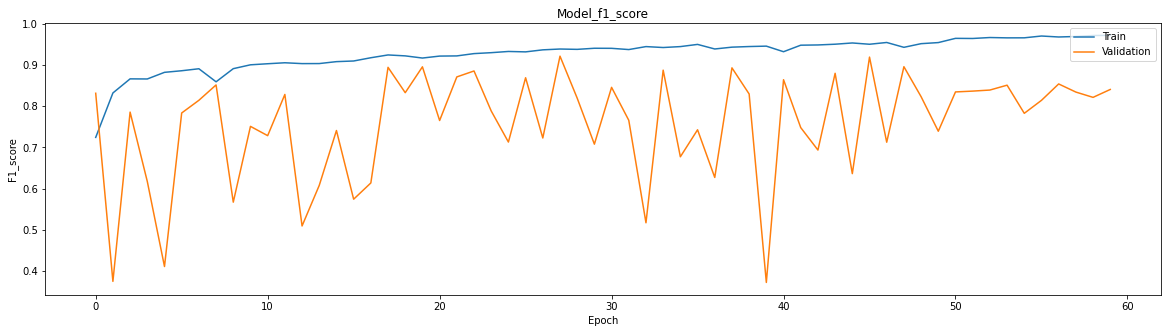

In [ ]:

# Plot training & validation f1_score values

plt.figure(figsize=(20,5))
plt.plot(history_1_Binary_model_Xception.history['f1_score'] + history_2_Binary_model_Xception.history['f1_score'] + history_3_Binary_model_Xception.history['f1_score'])
plt.plot(history_1_Binary_model_Xception.history['val_f1_score'] + history_2_Binary_model_Xception.history['val_f1_score'] + history_3_Binary_model_Xception.history['val_f1_score'])
plt.title('Model_f1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**OBSERVATIONS:**

1. Recall values are quite low among all the metrics.

2. There are high fluctuations in all the metrics indicating insufficient 
training data.

3. The best validation f1-score is 0.92174 for the Xception Model.



**Evaluation On the Test Dataset**

In [ ]:
# loading all models

model_1 = load_model('/content/drive/My Drive/Case_Study_2/Binary_models/Binary_model_vgg16.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
model_1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

model_2 = load_model('/content/drive/My Drive/Case_Study_2/Binary_models/Binary_model_InceptionV3.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
model_2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

model_3 = load_model('/content/drive/My Drive/Case_Study_2/Binary_models/Binary_model_Xception.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
model_3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

 
# datagenerators
train_datagen_Evaluate_Binary = test_datagen_Binary.flow_from_dataframe(dataframe = X_tr_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

validation_datagen_Evaluate_Binary = test_datagen_Binary.flow_from_dataframe(dataframe = X_cv_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

test_datagen_Evaluate_Binary = test_datagen_Binary.flow_from_dataframe(dataframe = X_te_1,directory=root_path,
                                                                x_col="Id",y_col="defect_present",target_size=(299,299),batch_size=16,
                                                                class_mode='binary')

Found 10066 validated image filenames belonging to 2 classes.
Found 1245 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.


In [ ]:
# vgg scores
train_scores_vgg16 = model_1.evaluate(train_datagen_Evaluate_Binary,verbose=1)
cv_scores_vgg16 = model_1.evaluate(validation_datagen_Evaluate_Binary,verbose=1)
test_Scores_vgg16 = model_1.evaluate(test_datagen_Evaluate_Binary,verbose=1)

# InceptionV3 scores
train_scores_InceptionV3 = model_2.evaluate(train_datagen_Evaluate_Binary,verbose=1)
cv_scores_InceptionV3 = model_2.evaluate(validation_datagen_Evaluate_Binary,verbose=1)
test_Scores_InceptionV3 = model_2.evaluate(test_datagen_Evaluate_Binary,verbose=1)

# Xception scores
train_scores_Xception = model_3.evaluate(train_datagen_Evaluate_Binary,verbose=1)
cv_scores_Xception = model_3.evaluate(validation_datagen_Evaluate_Binary,verbose=1)
test_Scores_Xception = model_3.evaluate(test_datagen_Evaluate_Binary,verbose=1)

79/79 [==============================] - 14s 174ms/step - loss: 0.2632 - accuracy: 0.9220 - precision: 0.8975 - recall: 0.9666 - f1_score: 0.9272


In [ ]:
# vgg_model_Results

a = pd.DataFrame([train_scores_vgg16,cv_scores_vgg16,test_Scores_vgg16],columns = ['loss','accuracy','precision','recall','f1_score'],index = ['Train','Cv','Test'] )
vgg_model_Results = a.T
vgg_model_Results

,Train,Cv,Test
loss,0.479523,0.582843,0.599867
accuracy,0.751739,0.734137,0.748608
precision,0.706855,0.702112,0.708761
recall,0.914082,0.885735,0.900239
f1_score,0.788696,0.773296,0.784693


In [ ]:
# InceptionV3_model_Results

b = pd.DataFrame([train_scores_InceptionV3,cv_scores_InceptionV3,test_Scores_InceptionV3],columns = ['loss','accuracy','precision','recall','f1_score'],index = ['Train','Cv','Test'] )
InceptionV3_model_Results = b.T
InceptionV3_model_Results

,Train,Cv,Test
loss,0.240576,0.253434,0.234783
accuracy,0.902543,0.897189,0.911695
precision,0.924530,0.915740,0.955650
recall,0.889528,0.883826,0.873829
f1_score,0.901310,0.893101,0.906807


In [ ]:
# Xception_model_Results

c = pd.DataFrame([train_scores_Xception,cv_scores_Xception,test_Scores_Xception],columns = ['loss','accuracy','precision','recall','f1_score'],index = ['Train','Cv','Test'] )
Xception_model_Results = c.T
Xception_model_Results

,Train,Cv,Test
loss,0.241541,0.279737,0.263171
accuracy,0.928273,0.919679,0.922037
precision,0.899078,0.887751,0.897513
recall,0.976429,0.974945,0.966561
f1_score,0.932443,0.925967,0.927178


**OBSERVATIONS:**

1. Best results on the unseen test data is given by the Xception model with an accuracy of 92.2037% and an F1_score of 0.927178.



## 2. MULTI LABEL CLASSIFICATION MODEL :

><font size="4" color='blue'>Data Pipeline for Multi Label Classification Model</font>

In [ ]:
X_tr_2 = X_tr[['Id','Class1','Class2','Class3','Class4']][X_tr['defect_present'] == 1]
X_cv_2 = X_cv[['Id','Class1','Class2','Class3','Class4']][X_cv['defect_present'] == 1]
X_te_2 = X_te[['Id','Class1','Class2','Class3','Class4']][X_te['defect_present'] == 1]

X_tr_2.head()

,Id,Class1,Class2,Class3,Class4
5610,8f8104c9c.jpg,0,0,0,1
3509,b8b4d7133.jpg,0,0,0,1
2769,d44db82d2.jpg,0,0,1,0
12008,012d29df4.jpg,0,0,1,0
2834,d37fb426f.jpg,0,0,1,1


In [ ]:
# Image Augmentaion using tf.ImageDataGenerator

train_datagen_Multi = ImageDataGenerator(rescale=1./255.,rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)
test_datagen_Multi = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_datagen_4 = train_datagen_Multi.flow_from_dataframe(dataframe = X_tr_2,directory=root_path,
                                                                x_col="Id",y_col=['Class1','Class2','Class3','Class4'],target_size=(299,299),batch_size=16,
                                                                class_mode='raw')

cv_datagen_4 = test_datagen_Multi.flow_from_dataframe(dataframe = X_cv_2,directory=root_path,
                                                                x_col="Id",y_col=['Class1','Class2','Class3','Class4'],target_size=(299,299),batch_size=16,
                                                                class_mode='raw')

Found 5099 validated image filenames.
Found 900 validated image filenames.


><font size="4" color='blue'>Xception Model For Multi Label Classification:</font>

In [ ]:
Xception_model =  Xception(include_top=False,input_shape=(299, 299, 3))


x = Xception_model.output

x = GlobalAveragePooling2D()(x)

# Dense Block 1 

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense Block 2

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 3

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 4

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

outputlayer = Dense(4, activation='sigmoid')(x)

Multi_model_Xception = Model(inputs = Xception_model.input, outputs = outputlayer)

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
Multi_model_Xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model_filepath_Xception_Multi = '/content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_Xception.h5'
model_checkpoint_Xception_Multi = ModelCheckpoint(filepath = model_filepath_Xception_Multi, monitor = 'val_f1_score',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir_Xception_Multi = '/content/drive/MyDrive/Case_Study_2/logs_Multi_Label_model_Xception/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_Xception_Multi = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir_Xception_Multi,histogram_freq = 0)

In [ ]:
Multi_model_Xception.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

In [ ]:
# config = tf.compat.v1.ConfigProto
# config.gpu_options.allow_growth = True

In [ ]:
history_1_Multi_model_Xception = Multi_model_Xception.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_Xception_Multi,tensorboard_callback_Xception_Multi])

Epoch 1/25
319/319 [==============================] - 4448s 14s/step - loss: 0.4368 - accuracy: 0.7018 - precision: 0.6998 - recall: 0.7138 - f1_score: 0.6947 - val_loss: 0.5867 - val_accuracy: 0.5478 - val_precision: 0.6007 - val_recall: 0.7296 - val_f1_score: 0.6572

Epoch 00001: val_f1_score improved from -inf to 0.65716, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_Xception.h5
Epoch 2/25
319/319 [==============================] - 231s 723ms/step - loss: 0.2566 - accuracy: 0.7894 - precision: 0.8135 - recall: 0.7892 - f1_score: 0.7987 - val_loss: 0.2688 - val_accuracy: 0.8311 - val_precision: 0.8530 - val_recall: 0.7964 - val_f1_score: 0.8229

Epoch 00002: val_f1_score improved from 0.65716 to 0.82287, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_Xception.h5
Epoch 3/25
319/319 [==============================] - 231s 723ms/step - loss: 0.2175 - accuracy: 0.8175 - precision: 0.8457 - recall: 0.8127

In [ ]:
Multi_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_Xception_weights_after25_epochs.h5')

In [ ]:
history_1_Multi_model_Xception.history

{'accuracy': [0.7544616460800171,
  0.7874093055725098,
  0.8127083778381348,
  0.8244754076004028,
  0.8333006501197815,
  0.8350657224655151,
  0.8264365792274475,
  0.8403608798980713,
  0.8431065082550049,
  0.8507550358772278,
  0.8576191663742065,
  0.8519317507743835,
  0.8548734784126282,
  0.8558540940284729,
  0.8548734784126282,
  0.8584036231040955,
  0.8587958216667175,
  0.8662483096122742,
  0.8689939379692078,
  0.8719356656074524,
  0.8725240230560303,
  0.873700737953186,
  0.8838987946510315,
  0.886448323726654,
  0.8831143379211426],
 'f1_score': [0.7492524981498718,
  0.7966554760932922,
  0.8231027722358704,
  0.8372833132743835,
  0.8465768694877625,
  0.8491811752319336,
  0.8438745737075806,
  0.8576215505599976,
  0.860414981842041,
  0.8650158047676086,
  0.8701658844947815,
  0.8701265454292297,
  0.871874988079071,
  0.8709985613822937,
  0.8736320734024048,
  0.8769129514694214,
  0.876039981842041,
  0.8815321922302246,
  0.8885952234268188,
  0.89177507

In [ ]:
Multi_model_Xception.load_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_Xception_weights_after25_epochs.h5')

In [ ]:
history_2_Multi_model_Xception = Multi_model_Xception.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_Xception_Multi,tensorboard_callback_Xception_Multi])

Epoch 1/25
319/319 [==============================] - 232s 727ms/step - loss: 0.1223 - accuracy: 0.8855 - precision: 0.9269 - recall: 0.8839 - f1_score: 0.9036 - val_loss: 0.1773 - val_accuracy: 0.8733 - val_precision: 0.8997 - val_recall: 0.8747 - val_f1_score: 0.8857

Epoch 00001: val_f1_score did not improve from 0.90309
Epoch 2/25
319/319 [==============================] - 231s 722ms/step - loss: 0.1257 - accuracy: 0.8833 - precision: 0.9253 - recall: 0.8830 - f1_score: 0.9026 - val_loss: 0.1998 - val_accuracy: 0.8433 - val_precision: 0.8586 - val_recall: 0.8330 - val_f1_score: 0.8446

Epoch 00002: val_f1_score did not improve from 0.90309
Epoch 3/25
319/319 [==============================] - 231s 724ms/step - loss: 0.1244 - accuracy: 0.8863 - precision: 0.9240 - recall: 0.8890 - f1_score: 0.9051 - val_loss: 0.2765 - val_accuracy: 0.7978 - val_precision: 0.8354 - val_recall: 0.8009 - val_f1_score: 0.8168

Epoch 00003: val_f1_score did not improve from 0.90309
Epoch 4/25
319/319 [==

In [ ]:
history_2_Multi_model_Xception.history

{'accuracy': [0.8854677677154541,
  0.8833104372024536,
  0.886252224445343,
  0.887232780456543,
  0.880760908126831,
  0.8868405818939209,
  0.8997842669487,
  0.8919395804405212,
  0.8958619236946106,
  0.8976269960403442,
  0.8988037109375,
  0.9003726243972778,
  0.9017454385757446,
  0.9068444967269897,
  0.9084134101867676,
  0.911747395992279,
  0.9091978669166565,
  0.9070405960083008,
  0.9099823236465454,
  0.9111590385437012,
  0.9123357534408569,
  0.9088056683540344,
  0.9090017676353455,
  0.9180231690406799,
  0.9160619974136353],
 'f1_score': [0.903590977191925,
  0.9026119709014893,
  0.9050982594490051,
  0.906574010848999,
  0.9013025164604187,
  0.9051474332809448,
  0.918009340763092,
  0.9129937291145325,
  0.9161009788513184,
  0.918239414691925,
  0.9189358353614807,
  0.9212855100631714,
  0.9213638305664062,
  0.9214836955070496,
  0.927051305770874,
  0.930000901222229,
  0.927251935005188,
  0.9254077672958374,
  0.9309757351875305,
  0.929217517375946,
  0

In [ ]:
Multi_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_Xception_weights_after50epochs.h5')

In [ ]:
Multi_model_Xception.load_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_Xception_weights_after50epochs.h5')

In [ ]:
history_3_Multi_model_Xception = Multi_model_Xception.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_Xception_Multi,tensorboard_callback_Xception_Multi])

Epoch 1/25
319/319 [==============================] - 4337s 13s/step - loss: 0.0890 - accuracy: 0.9174 - precision: 0.9552 - recall: 0.9231 - f1_score: 0.9380 - val_loss: 0.1045 - val_accuracy: 0.9056 - val_precision: 0.9511 - val_recall: 0.9169 - val_f1_score: 0.9326

Epoch 00001: val_f1_score improved from -inf to 0.93255, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_Xception.h5
Epoch 2/25
319/319 [==============================] - 592s 2s/step - loss: 0.0821 - accuracy: 0.9199 - precision: 0.9564 - recall: 0.9256 - f1_score: 0.9398 - val_loss: 0.2429 - val_accuracy: 0.8611 - val_precision: 0.8783 - val_recall: 0.8824 - val_f1_score: 0.8788

Epoch 00002: val_f1_score did not improve from 0.93255
Epoch 3/25
319/319 [==============================] - 592s 2s/step - loss: 0.0842 - accuracy: 0.9154 - precision: 0.9507 - recall: 0.9283 - f1_score: 0.9385 - val_loss: 0.1567 - val_accuracy: 0.8633 - val_precision: 0.8891 - val_recall: 0.8757 - val

In [ ]:
Multi_model_Xception.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_Xception_weights_after75epochs.h5')

In [ ]:
history_3_Multi_model_Xception.history

{'accuracy': [0.9148852825164795,
  0.9158658385276794,
  0.9154736399650574,
  0.9144930243492126,
  0.9178270101547241,
  0.9190037250518799,
  0.918415367603302,
  0.9209648966789246,
  0.9176309108734131,
  0.9168464541435242,
  0.9225338101387024,
  0.9201804399490356,
  0.9231221675872803,
  0.9141008257865906,
  0.9278289675712585,
  0.9264561533927917,
  0.9284173250198364,
  0.9225338101387024,
  0.9264561533927917,
  0.9246911406517029,
  0.9233183264732361,
  0.9239066243171692,
  0.9235144257545471,
  0.9225338101387024,
  0.9276328682899475],
 'f1_score': [0.9351711869239807,
  0.9354277849197388,
  0.9362164735794067,
  0.9357998967170715,
  0.9378279447555542,
  0.9389892220497131,
  0.940008282661438,
  0.9374535083770752,
  0.9363874197006226,
  0.9372431635856628,
  0.9407840371131897,
  0.940916895866394,
  0.9413129091262817,
  0.9348016381263733,
  0.9476593732833862,
  0.9489867687225342,
  0.9473761916160583,
  0.9435425996780396,
  0.9468777775764465,
  0.946500

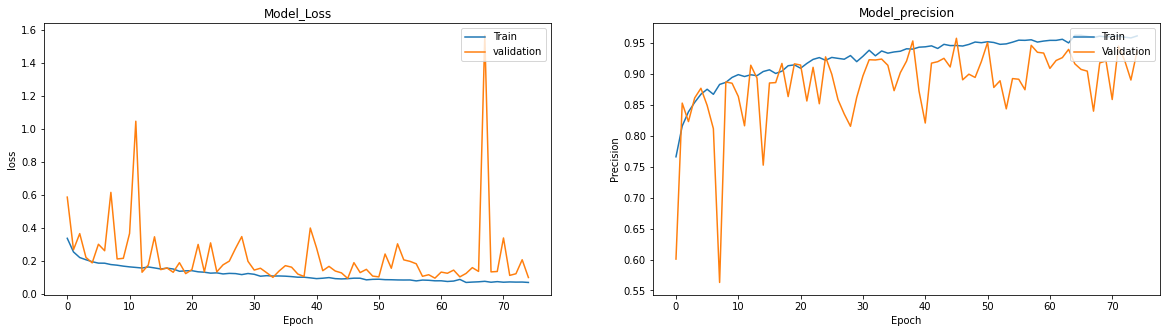

In [ ]:
# Plotting training & validation loss values (Multi Label Xception Model)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_Multi_model_Xception.history['loss'] + history_2_Multi_model_Xception.history['loss'] + history_3_Multi_model_Xception.history['loss'])
plt.plot(history_1_Multi_model_Xception.history['val_loss'] + history_2_Multi_model_Xception.history['val_loss'] + history_3_Multi_model_Xception.history['val_loss'])
plt.title('Model_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_Multi_model_Xception.history['precision'] + history_2_Multi_model_Xception.history['precision'] + history_3_Multi_model_Xception.history['precision'])
plt.plot(history_1_Multi_model_Xception.history['val_precision'] + history_2_Multi_model_Xception.history['val_precision'] + history_3_Multi_model_Xception.history['val_precision'])
plt.title('Model_precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

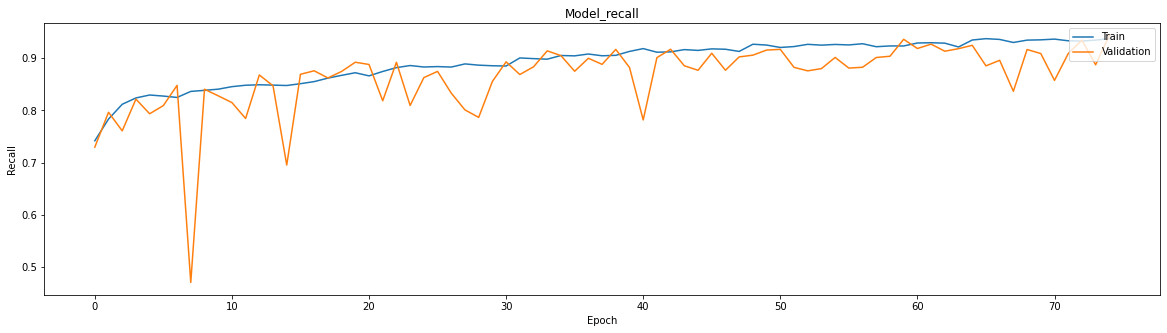

In [ ]:
# Plot training & validation Recall values
plt.figure(figsize=(20,5))
# plt.subplot(121)
plt.plot(history_1_Multi_model_Xception.history['recall'] + history_2_Multi_model_Xception.history['recall'] + history_3_Multi_model_Xception.history['recall'])
plt.plot(history_1_Multi_model_Xception.history['val_recall'] + history_2_Multi_model_Xception.history['val_recall'] + history_3_Multi_model_Xception.history['val_recall'])
plt.title('Model_recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

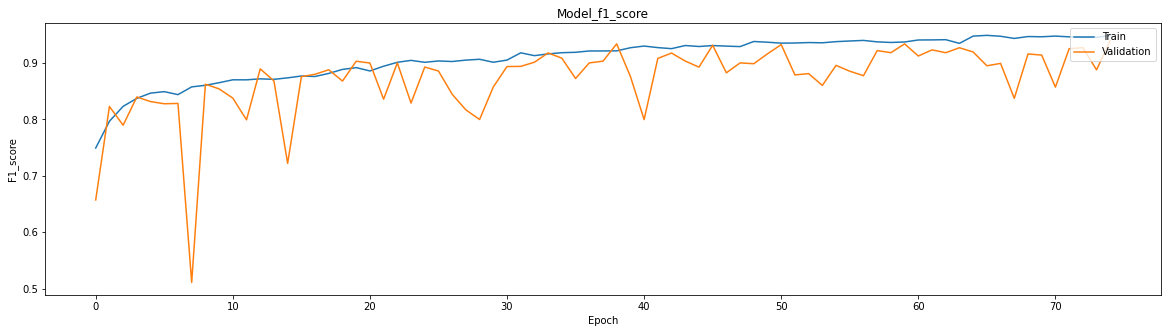

In [ ]:
# Plot training & validation f1_score values

plt.figure(figsize=(20,5))
plt.plot(history_1_Multi_model_Xception.history['f1_score'] + history_2_Multi_model_Xception.history['f1_score'] + history_3_Multi_model_Xception.history['f1_score'])
plt.plot(history_1_Multi_model_Xception.history['val_f1_score'] + history_2_Multi_model_Xception.history['val_f1_score'] + history_3_Multi_model_Xception.history['val_f1_score'])
plt.title('Model_f1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  Graph is smooth for the train data , but for the validation set the graph is showing clear fluctuations.

2. Therefore the train data is not sufficient for the model.

3. Precision Values are good in the above model compared to the Recall.

><font size="4" color='blue'>InceptionResNetV2 Model For Multi Label Classification:</font>

In [ ]:
InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', input_shape=(299,299,3), include_top=False)

x = InceptionResNetV2_model.output

x = GlobalAveragePooling2D()(x)

# Dense Block 1 

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense Block 2

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 3

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Block 4

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

outputlayer = Dense(4, activation='sigmoid')(x)


Multi_model_InceptionResNetV2 = Model(inputs = InceptionResNetV2_model.input, outputs = outputlayer)

219062272/219055592 [==============================] - 7s 0us/step


In [ ]:
Multi_model_InceptionResNetV2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 149, 149, 32) 96          conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_211[0][0]    
____________________________________________________________________________________________

In [ ]:
model_filepath_InceptionResNetV2_Multi = '/content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5'
model_checkpoint_InceptionResNetV2_Multi = ModelCheckpoint(filepath = model_filepath_InceptionResNetV2_Multi, monitor = 'val_f1_score',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir_InceptionResNetV2_Multi = '/content/drive/MyDrive/Case_Study_2/logs_Multi_Label_model_InceptionResNetV2/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_InceptionResNetV2_Multi = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir_InceptionResNetV2_Multi,histogram_freq = 0)

In [ ]:
Multi_model_InceptionResNetV2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

In [ ]:
history_1_Multi_model_InceptionResNetV2 = Multi_model_InceptionResNetV2.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_InceptionResNetV2_Multi,tensorboard_callback_InceptionResNetV2_Multi])

Epoch 1/25
319/319 [==============================] - 207s 599ms/step - loss: 0.3599 - accuracy: 0.7369 - precision: 0.7526 - recall: 0.7197 - f1_score: 0.7338 - val_loss: 0.4462 - val_accuracy: 0.7600 - val_precision: 0.7585 - val_recall: 0.5179 - val_f1_score: 0.6098

Epoch 00001: val_f1_score improved from -inf to 0.60982, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 2/25
319/319 [==============================] - 185s 579ms/step - loss: 0.2858 - accuracy: 0.7481 - precision: 0.7738 - recall: 0.7481 - f1_score: 0.7590 - val_loss: 0.2681 - val_accuracy: 0.7733 - val_precision: 0.7884 - val_recall: 0.7757 - val_f1_score: 0.7803

Epoch 00002: val_f1_score improved from 0.60982 to 0.78034, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 3/25
319/319 [==============================] - 185s 581ms/step - loss: 0.2441 - accuracy: 0.7958 - precision: 0.81

In [ ]:
history_1_Multi_model_InceptionResNetV2.history

{'accuracy': [0.7430868744850159,
  0.7587762475013733,
  0.791920006275177,
  0.8013336062431335,
  0.805648148059845,
  0.8148656487464905,
  0.8264365792274475,
  0.8270248770713806,
  0.82996666431427,
  0.8352618217468262,
  0.8440870642662048,
  0.8440870642662048,
  0.849382221698761,
  0.8558540940284729,
  0.8562463521957397,
  0.8536968231201172,
  0.868013322353363,
  0.867621123790741,
  0.8636987805366516,
  0.8752696514129639,
  0.8717395663261414,
  0.8727201223373413,
  0.8774269223213196,
  0.8740929365158081,
  0.8829182386398315],
 'f1_score': [0.7463670969009399,
  0.7705205082893372,
  0.7977198958396912,
  0.8135086297988892,
  0.8168411254882812,
  0.8313764333724976,
  0.8377538919448853,
  0.8406718373298645,
  0.8452224135398865,
  0.8515654802322388,
  0.8579787611961365,
  0.8581835031509399,
  0.864711582660675,
  0.8726020455360413,
  0.87236487865448,
  0.8706029653549194,
  0.8804312944412231,
  0.8843530416488647,
  0.8792322874069214,
  0.8925795555114

In [ ]:
Multi_model_InceptionResNetV2.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after25epochs.h5')

In [ ]:
Multi_model_InceptionResNetV2.load_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after25epochs.h5')

In [ ]:
history_2_Multi_model_InceptionResNetV2 = Multi_model_InceptionResNetV2.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_InceptionResNetV2_Multi,tensorboard_callback_InceptionResNetV2_Multi])

Epoch 1/25
319/319 [==============================] - 1655s 5s/step - loss: 0.1242 - accuracy: 0.8877 - precision: 0.9221 - recall: 0.8899 - f1_score: 0.9045 - val_loss: 0.1527 - val_accuracy: 0.8644 - val_precision: 0.8963 - val_recall: 0.8886 - val_f1_score: 0.8912

Epoch 00001: val_f1_score improved from -inf to 0.89122, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 2/25
319/319 [==============================] - 236s 739ms/step - loss: 0.1239 - accuracy: 0.8877 - precision: 0.9197 - recall: 0.8946 - f1_score: 0.9057 - val_loss: 0.2284 - val_accuracy: 0.8011 - val_precision: 0.8385 - val_recall: 0.7936 - val_f1_score: 0.8135

Epoch 00002: val_f1_score did not improve from 0.89122
Epoch 3/25
319/319 [==============================] - 234s 734ms/step - loss: 0.1258 - accuracy: 0.8884 - precision: 0.9188 - recall: 0.8901 - f1_score: 0.9029 - val_loss: 0.1436 - val_accuracy: 0.8667 - val_precision: 0.9107 - val_recall

In [ ]:
history_2_Multi_model_InceptionResNetV2.history

{'accuracy': [0.8840948939323425,
  0.886448323726654,
  0.8842910528182983,
  0.893312394618988,
  0.892920196056366,
  0.8903706669807434,
  0.899980366230011,
  0.8976269960403442,
  0.8970386385917664,
  0.9044910669326782,
  0.8988037109375,
  0.9046871662139893,
  0.905667781829834,
  0.9080211520195007,
  0.9035105109214783,
  0.9091978669166565,
  0.9107668399810791,
  0.9105706810951233,
  0.9119434952735901,
  0.9109629392623901,
  0.9133163094520569,
  0.9082173109054565,
  0.9152774810791016,
  0.9160619974136353,
  0.9170425534248352],
 'f1_score': [0.9001950025558472,
  0.9051501154899597,
  0.9043250679969788,
  0.9115785956382751,
  0.9103254675865173,
  0.9089130759239197,
  0.9174386858940125,
  0.9141197800636292,
  0.9146080017089844,
  0.9194505214691162,
  0.915642499923706,
  0.9219849109649658,
  0.9226301908493042,
  0.925419807434082,
  0.9237126708030701,
  0.9281562566757202,
  0.9308857321739197,
  0.9280430674552917,
  0.9287534356117249,
  0.9279167056083

In [ ]:
Multi_model_InceptionResNetV2.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after50epochs.h5')

In [ ]:
Multi_model_InceptionResNetV2.load_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after50epochs.h5')

In [ ]:
from keras import backend as K
K.set_value(Multi_model_InceptionResNetV2.optimizer.learning_rate, 0.0001)

In [ ]:
history_3_Multi_model_InceptionResNetV2 = Multi_model_InceptionResNetV2.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_InceptionResNetV2_Multi,tensorboard_callback_InceptionResNetV2_Multi])

Epoch 1/25
319/319 [==============================] - 235s 735ms/step - loss: 0.0682 - accuracy: 0.9274 - precision: 0.9577 - recall: 0.9412 - f1_score: 0.9486 - val_loss: 0.1243 - val_accuracy: 0.8911 - val_precision: 0.9252 - val_recall: 0.8896 - val_f1_score: 0.9060

Epoch 00001: val_f1_score did not improve from 0.90945
Epoch 2/25
319/319 [==============================] - 235s 735ms/step - loss: 0.0561 - accuracy: 0.9339 - precision: 0.9709 - recall: 0.9496 - f1_score: 0.9594 - val_loss: 0.1178 - val_accuracy: 0.8878 - val_precision: 0.9290 - val_recall: 0.9035 - val_f1_score: 0.9146

Epoch 00002: val_f1_score improved from 0.90945 to 0.91460, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 3/25
319/319 [==============================] - 236s 740ms/step - loss: 0.0568 - accuracy: 0.9339 - precision: 0.9682 - recall: 0.9482 - f1_score: 0.9573 - val_loss: 0.1105 - val_accuracy: 0.9011 - val_precision: 0.9271 - val_r

In [ ]:
history_3_Multi_model_InceptionResNetV2.history

{'accuracy': [0.9274367690086365,
  0.9339085817337036,
  0.9339085817337036,
  0.9337124824523926,
  0.936850368976593,
  0.936850368976593,
  0.9364581108093262,
  0.9380270838737488,
  0.9374387264251709,
  0.9411649107933044,
  0.9413610696792603,
  0.9443027973175049,
  0.942733883857727,
  0.9425377249717712,
  0.9454795122146606,
  0.9417532682418823,
  0.9443027973175049,
  0.9441066980361938,
  0.9405766129493713,
  0.9480290412902832,
  0.943714439868927,
  0.9460678696632385,
  0.9468523263931274,
  0.942733883857727,
  0.943518340587616],
 'f1_score': [0.9485892653465271,
  0.959415853023529,
  0.9572914838790894,
  0.9582040905952454,
  0.9610328674316406,
  0.9607542753219604,
  0.9625468850135803,
  0.9609218239784241,
  0.9638274908065796,
  0.9671131372451782,
  0.9663760662078857,
  0.9672351479530334,
  0.967228353023529,
  0.9667001366615295,
  0.969773530960083,
  0.9680800437927246,
  0.970569372177124,
  0.9696128368377686,
  0.9693764448165894,
  0.9731681346893

In [ ]:
Multi_model_InceptionResNetV2.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after75epochs.h5')

In [ ]:
Multi_model_InceptionResNetV2.load_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after75epochs.h5')

In [ ]:
K.set_value(Multi_model_InceptionResNetV2.optimizer.learning_rate, 0.00001)

In [ ]:
history_4_Multi_model_InceptionResNetV2 = Multi_model_InceptionResNetV2.fit_generator(train_datagen_4, validation_data = cv_datagen_4, epochs = 25, verbose=1, callbacks = [model_checkpoint_InceptionResNetV2_Multi,tensorboard_callback_InceptionResNetV2_Multi])

Epoch 1/25
319/319 [==============================] - 1654s 5s/step - loss: 0.0328 - accuracy: 0.9449 - precision: 0.9810 - recall: 0.9712 - f1_score: 0.9756 - val_loss: 0.1249 - val_accuracy: 0.8989 - val_precision: 0.9324 - val_recall: 0.9120 - val_f1_score: 0.9210

Epoch 00001: val_f1_score improved from -inf to 0.92097, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 2/25
319/319 [==============================] - 232s 726ms/step - loss: 0.0330 - accuracy: 0.9377 - precision: 0.9801 - recall: 0.9727 - f1_score: 0.9759 - val_loss: 0.1149 - val_accuracy: 0.9100 - val_precision: 0.9345 - val_recall: 0.9179 - val_f1_score: 0.9249

Epoch 00002: val_f1_score improved from 0.92097 to 0.92486, saving model to /content/drive/MyDrive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5
Epoch 3/25
319/319 [==============================] - 232s 725ms/step - loss: 0.0318 - accuracy: 0.9442 - precision: 0.9836

In [ ]:
history_4_Multi_model_InceptionResNetV2.history

{'accuracy': [0.9466562271118164,
  0.9441066980361938,
  0.9444988965988159,
  0.9448911547660828,
  0.9448911547660828,
  0.9460678696632385,
  0.9450872540473938,
  0.9480290412902832,
  0.9470484256744385,
  0.9448911547660828,
  0.9484212398529053,
  0.9452834129333496,
  0.9439105987548828,
  0.9476367831230164,
  0.9484212398529053,
  0.9476367831230164,
  0.9478328824043274,
  0.9446950554847717,
  0.9462639689445496,
  0.9456756114959717,
  0.9466562271118164,
  0.9472445845603943,
  0.9452834129333496,
  0.9486173987388611,
  0.9470484256744385],
 'f1_score': [0.9756784439086914,
  0.975482702255249,
  0.9767266511917114,
  0.9761524796485901,
  0.9744504690170288,
  0.9748884439468384,
  0.9749341607093811,
  0.9751481413841248,
  0.9774630069732666,
  0.9759801030158997,
  0.9766241312026978,
  0.9747421741485596,
  0.9756479263305664,
  0.975497841835022,
  0.9773054718971252,
  0.9770538210868835,
  0.9775028824806213,
  0.9746251702308655,
  0.9763036370277405,
  0.97584

In [ ]:
Multi_model_InceptionResNetV2.save_weights('/content/drive/MyDrive/Case_Study_2/Multi_Model_InceptionResNetV2_weights_after100epochs.h5')

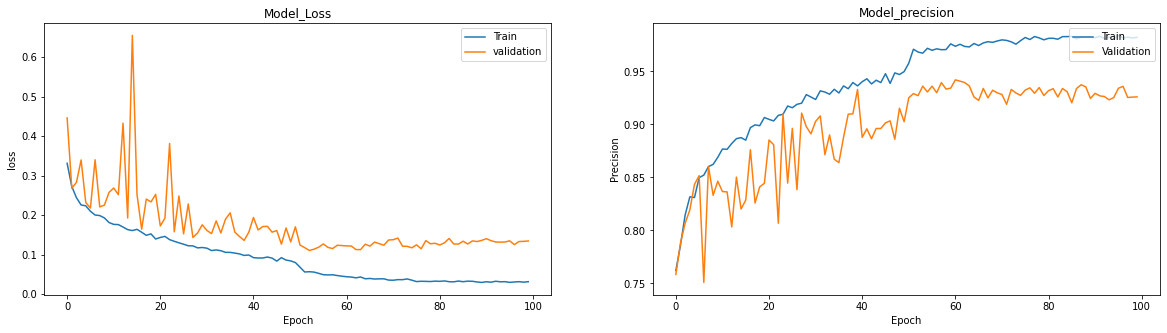

In [ ]:
# Plotting training & validation loss values (Multi Label InceptionResNetV2 Model)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_Multi_model_InceptionResNetV2['loss'] + history_2_Multi_model_InceptionResNetV2['loss'] + history_3_Multi_model_InceptionResNetV2['loss'] + history_4_Multi_model_InceptionResNetV2['loss'])
plt.plot(history_1_Multi_model_InceptionResNetV2['val_loss'] + history_2_Multi_model_InceptionResNetV2['val_loss'] + history_3_Multi_model_InceptionResNetV2['val_loss'] + history_4_Multi_model_InceptionResNetV2['val_loss'])
plt.title('Model_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_Multi_model_InceptionResNetV2['precision'] + history_2_Multi_model_InceptionResNetV2['precision'] + history_3_Multi_model_InceptionResNetV2['precision'] + history_4_Multi_model_InceptionResNetV2['precision'])
plt.plot(history_1_Multi_model_InceptionResNetV2['val_precision'] + history_2_Multi_model_InceptionResNetV2['val_precision'] + history_3_Multi_model_InceptionResNetV2['val_precision'] + history_4_Multi_model_InceptionResNetV2['val_precision'])
plt.title('Model_precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

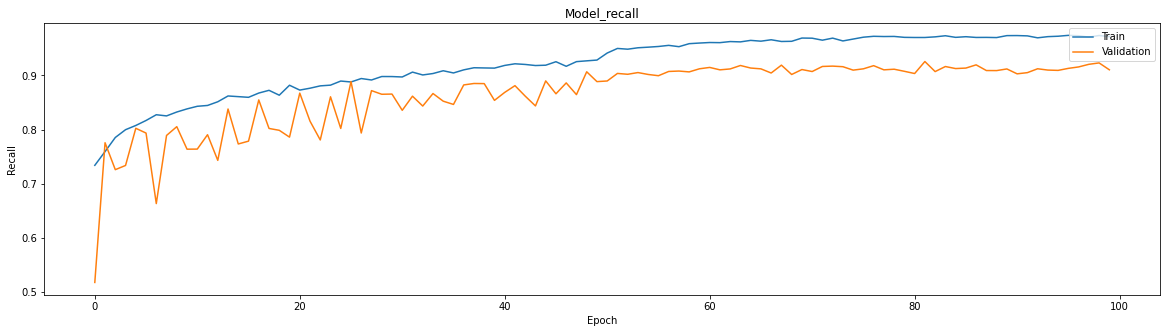

In [ ]:
# Plot training & validation Recall values
plt.figure(figsize=(20,5))
# plt.subplot(121)
plt.plot(history_1_Multi_model_InceptionResNetV2['recall'] + history_2_Multi_model_InceptionResNetV2['recall'] + history_3_Multi_model_InceptionResNetV2['recall'] + history_4_Multi_model_InceptionResNetV2['recall'])
plt.plot(history_1_Multi_model_InceptionResNetV2['val_recall'] + history_2_Multi_model_InceptionResNetV2['val_recall'] + history_3_Multi_model_InceptionResNetV2['val_recall'] + history_4_Multi_model_InceptionResNetV2['val_recall'])
plt.title('Model_recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

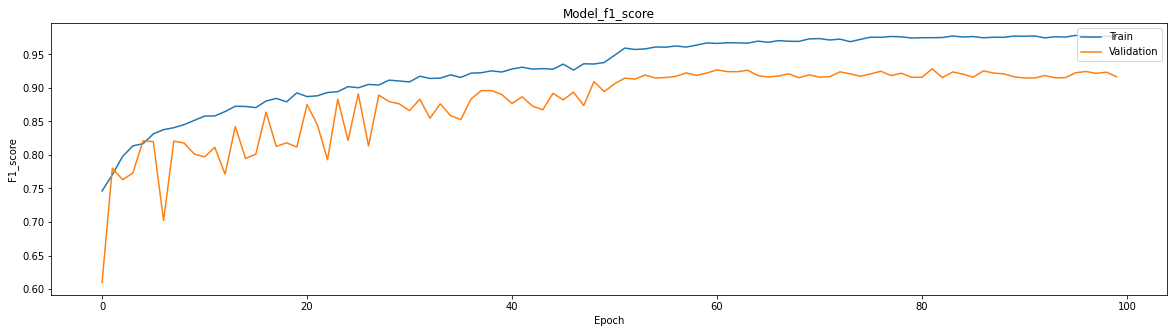

In [ ]:
# Plot training & validation f1_score values

plt.figure(figsize=(20,5))
plt.plot(history_1_Multi_model_InceptionResNetV2['f1_score'] + history_2_Multi_model_InceptionResNetV2['f1_score'] + history_3_Multi_model_InceptionResNetV2['f1_score'] + history_4_Multi_model_InceptionResNetV2['f1_score'])
plt.plot(history_1_Multi_model_InceptionResNetV2['val_f1_score'] + history_2_Multi_model_InceptionResNetV2['val_f1_score'] + history_3_Multi_model_InceptionResNetV2['val_f1_score'] + history_4_Multi_model_InceptionResNetV2['val_f1_score'])
plt.title('Model_f1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  Precision Values on the Validation Set showed high variations compared to Recall.

2. The train data is not sufficient for the model.


**Evaluation on the Test Data Set**



In [ ]:
# loading the two models trained for Multi Label Classification

model_4 = load_model('/content/drive/My Drive/Case_Study_2/Multi_Label_models/Multi_Label_model_Xception.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
model_4.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

model_5 = load_model('/content/drive/My Drive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
model_5.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])


In [ ]:
# datagenerators
train_datagen_Evaluate_Multi_Label = test_datagen_Multi.flow_from_dataframe(dataframe = X_tr_2,directory=root_path,
                                                                x_col = "Id",y_col = ['Class1','Class2','Class3','Class4'], target_size = (299,299), batch_size=16,
                                                                class_mode='raw')

validation_datagen_Evaluate_Multi_Label = test_datagen_Multi.flow_from_dataframe(dataframe = X_cv_2,directory=root_path,
                                                                x_col="Id",y_col=['Class1','Class2','Class3','Class4'],target_size=(299,299),batch_size=16,
                                                                class_mode='raw')

test_datagen_Evaluate_Multi_Label = test_datagen_Multi.flow_from_dataframe(dataframe = X_te_2,directory=root_path,
                                                                x_col="Id",y_col=['Class1','Class2','Class3','Class4'],target_size=(299,299),batch_size=16,
                                                                class_mode='raw')

Found 5339 validated image filenames.
Found 660 validated image filenames.
Found 667 validated image filenames.


In [ ]:
# Multi Label Xception Model scores
train_scores_Xception_Multi = model_4.evaluate(train_datagen_Evaluate_Multi_Label,verbose=1)
cv_scores_Xception_Multi = model_4.evaluate(validation_datagen_Evaluate_Multi_Label,verbose=1)
test_Scores_Xception_Multi = model_4.evaluate(test_datagen_Evaluate_Multi_Label,verbose=1)

# Multi Label InceptionResNetV2 Model scores
train_scores_InceptionResNetV2_Multi = model_5.evaluate(train_datagen_Evaluate_Multi_Label,verbose=1)
cv_scores_InceptionResNetV2_Multi = model_5.evaluate(validation_datagen_Evaluate_Multi_Label,verbose=1)
test_Scores_InceptionResNetV2_Multi = model_5.evaluate(test_datagen_Evaluate_Multi_Label,verbose=1)

42/42 [==============================] - 7s 162ms/step - loss: 0.1941 - accuracy: 0.8636 - precision: 0.8835 - recall: 0.8923 - f1_score: 0.8868


In [ ]:
# Multi_Label_Xception_Model_Results

c = pd.DataFrame([train_scores_Xception_Multi,cv_scores_Xception_Multi,test_Scores_Xception_Multi],columns = ['loss','accuracy','precision','recall','f1_score'],index = ['Train','Cv','Test'] )
Multi_Label_Xception_Model_Results = c.T
Multi_Label_Xception_Model_Results

,Train,Cv,Test
loss,0.205971,0.224967,0.239348
accuracy,0.879378,0.884848,0.878561
precision,0.882227,0.891606,0.876210
recall,0.895472,0.896869,0.896167
f1_score,0.887820,0.893056,0.885050


In [ ]:
# Multi_Label_InceptionResNetV2_Model_Results

d = pd.DataFrame([train_scores_InceptionResNetV2_Multi,cv_scores_InceptionResNetV2_Multi,test_Scores_InceptionResNetV2_Multi],columns = ['loss','accuracy','precision','recall','f1_score'],index = ['Train','Cv','Test'] )
Multi_Label_InceptionResNetV2_Model_Results = d.T
Multi_Label_InceptionResNetV2_Model_Results

,Train,Cv,Test
loss,0.163748,0.188442,0.194141
accuracy,0.876756,0.880303,0.863568
precision,0.907078,0.896011,0.883533
recall,0.896167,0.885660,0.892317
f1_score,0.900589,0.889657,0.886832


## 3. IMAGE SEGMENTATION MODEL :

><font size="4" color='blue'>Data Pipeline for Image Segmentation Model</font>

In [22]:
# Class1 images 
class_1_images_tr = X_tr[X_tr['Class1'] == 1][['Id','RLE1']]
class_1_images_tr.rename(columns = {'Id': 'ID', 'RLE1': 'ENCODING'}, inplace = True)

class_1_images_cv = X_cv[X_cv['Class1'] == 1][['Id','RLE1']]
class_1_images_cv.rename(columns = {'Id': 'ID', 'RLE1': 'ENCODING'}, inplace = True)

class_1_images_te = X_te[X_te['Class1'] == 1][['Id','RLE1']]
class_1_images_te.rename(columns = {'Id': 'ID', 'RLE1': 'ENCODING'}, inplace = True)

# Class2 images 
class_2_images_tr = X_tr[X_tr['Class2'] == 1][['Id','RLE2']]
class_2_images_tr.rename(columns = {'Id': 'ID', 'RLE2': 'ENCODING'}, inplace = True)

class_2_images_cv = X_cv[X_cv['Class2'] == 1][['Id','RLE2']]
class_2_images_cv.rename(columns = {'Id': 'ID', 'RLE2': 'ENCODING'}, inplace = True)

class_2_images_te = X_te[X_te['Class2'] == 1][['Id','RLE2']]
class_2_images_te.rename(columns = {'Id': 'ID', 'RLE2': 'ENCODING'}, inplace = True)

# Class3 images 
class_3_images_tr = X_tr[X_tr['Class3'] == 1][['Id','RLE3']]
class_3_images_tr.rename(columns = {'Id': 'ID', 'RLE3': 'ENCODING'}, inplace = True)

class_3_images_cv = X_cv[X_cv['Class3'] == 1][['Id','RLE3']]
class_3_images_cv.rename(columns = {'Id': 'ID', 'RLE3': 'ENCODING'}, inplace = True)

class_3_images_te = X_te[X_te['Class3'] == 1][['Id','RLE3']]
class_3_images_te.rename(columns = {'Id': 'ID', 'RLE3': 'ENCODING'}, inplace = True)

# Class4 images 
class_4_images_tr = X_tr[X_tr['Class4'] == 1][['Id','RLE4']]
class_4_images_tr.rename(columns = {'Id': 'ID', 'RLE4': 'ENCODING'}, inplace = True)

class_4_images_cv = X_cv[X_cv['Class4'] == 1][['Id','RLE4']]
class_4_images_cv.rename(columns = {'Id': 'ID', 'RLE4': 'ENCODING'}, inplace = True)

class_4_images_te = X_te[X_te['Class4'] == 1][['Id','RLE4']]
class_4_images_te.rename(columns = {'Id': 'ID', 'RLE4': 'ENCODING'}, inplace = True)

In [ ]:
import imgaug.augmenters as iaa

aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.Emboss(alpha=(1), strength=1)
# aug4 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
# aug5 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
class Segmentation_Train_Datagen(tf.keras.utils.Sequence):

    def __init__(self, dataframe, batch_size = 1,shuffle = False):
        
        super().__init__()
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.indices = np.arange(len(dataframe))
        self.w = 800
        self.h = 256
        self.root_path = '/content/drive/MyDrive/Case_Study_2/train_images/'

    def __getitem__(self, i): 
        
        indices = self.indices[i*self.batch_size:(i+1)*self.batch_size]
        
        Blank_image = np.empty((self.batch_size, self.h, self.w, 3), dtype = np.float32)

        Blank_map = np.empty((self.batch_size, self.h, self.w, 1), dtype = np.float32)
  
        
        for j,path in enumerate(self.dataframe['ID'].iloc[indices]):
            
            # Mask Formation      
            img = rle2mask(self.dataframe['ENCODING'].iloc[indices[j]])
            img1 = cv2.resize(img,(self.w,self.h))
            Blank_map[j,:,:,0] = img1
            
            # Original image
            img2 = cv2.imread(self.root_path + path, cv2.IMREAD_UNCHANGED)
            img2 = cv2.resize(img2,(self.w,self.h),interpolation=cv2.INTER_AREA)
            img2 = 1/255.*img2
            
            # Data Augmentation
            
            a = np.random.uniform()
            
            if a<0.2:
                img2 = aug1.augment_image(img2)
            elif a>0.8:
                img2 = aug3.augment_image(img2)
            elif 0.5<a<0.6:
                img2 = aug2.augment_image(img2)

            Blank_image[j,] = img2
                
        return Blank_image, Blank_map
  
    def __len__(self):
        return int(len(self.dataframe) // self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)

In [ ]:
class Segmentation_Test_Datagen(tf.keras.utils.Sequence):

    def __init__(self, dataframe, batch_size = 1,  shuffle = False):
        
        super().__init__()
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.indices = np.arange(len(dataframe))
        self.w = 800
        self.h = 256
        self.root_path = '/content/drive/MyDrive/Case_Study_2/train_images/'

    def __getitem__(self, i): 
        
        indices = self.indices[i*self.batch_size:(i+1)*self.batch_size]
        
        Blank_image = np.empty((self.batch_size, self.h, self.w, 3), dtype = np.float32)

        Blank_map = np.empty((self.batch_size, self.h, self.w, 1), dtype = np.float32)
  
        
        for j,path in enumerate(self.dataframe['ID'].iloc[indices]):
            
            # Mask Formation      
            img = rle2mask(self.dataframe['ENCODING'].iloc[indices[j]])
            img1 = cv2.resize(img,(self.w,self.h))
            Blank_map[j,:,:,0] = img1
            
            # Original image
            img2 = cv2.imread(self.root_path + path, cv2.IMREAD_UNCHANGED)
            img2 = cv2.resize(img2,(self.w,self.h),interpolation=cv2.INTER_AREA)
            img2 = 1/255.*img2   
            Blank_image[j,] = img2
                
        return Blank_image, Blank_map
  
    def __len__(self):
        return int(len(self.dataframe) // self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)

In [ ]:
# !pip install -U segmentation-models==0.2.1
# !pip install keras==2.3.1
# !pip install tensorflow==1.14

In [ ]:
# !pip install git+https://github.com/qubvel/segmentation_models

><font size="4" color='blue'>1. U-net Model with inceptionresnetv2 backbone</font>

In [ ]:
import segmentation_models as sm
from segmentation_models import Unet
Segmentation_model = Unet('inceptionresnetv2', encoder_weights='imagenet', classes=1, activation='sigmoid')

Segmentation Models: using `keras` framework.
219062272/219055592 [==============================] - 3s 0us/step


In [ ]:
Segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

><font size="4" color='blue'>Metrics: </font>

In [23]:
# Reference : https://stackoverflow.com/questions/59054564/dice-coefficient-above-1

def dice_coefficient(y_true, y_pred):
    
    y = K.flatten(y_true)
    y_predicted = K.flatten(y_pred)
    intersection = K.sum(y * y_predicted)
    
    return (2 * intersection + K.epsilon()) / (K.sum(y) + K.sum(y_predicted) + K.epsilon())

In [ ]:
Segmentation_model.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

><font size="4" color='blue'>Training the model for Class_1_Images:  </font>



>><font size="4" color='blue'>Dataloaders: </font>

In [ ]:
train_dataloader = Segmentation_Train_Datagen(class_1_images_tr, batch_size=8, shuffle=True)
Validation_dataloader = Segmentation_Test_Datagen(class_1_images_cv, batch_size=1, shuffle=False)

><font size="4" color='blue'>Callbacks: </font>

In [ ]:
model_filepath = '/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5'
model_checkpoint_seg_class1 = ModelCheckpoint(filepath = model_filepath, monitor = 'val_dice_coefficient',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir = '/content/drive/MyDrive/Case_Study_2/logs_segmentation_model_class1/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_seg_class1 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir,histogram_freq = 0)

In [ ]:
history_1_segmentation_class1 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class1,tensorboard_callback_seg_class1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
89/89 [==============================] - 222s 2s/step - loss: 0.9313 - dice_coefficient: 0.0687 - val_loss: 0.9385 - val_dice_coefficient: 0.0615

Epoch 00001: val_dice_coefficient improved from -inf to 0.06146, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 2/25
89/89 [==============================] - 142s 2s/step - loss: 0.6109 - dice_coefficient: 0.3891 - val_loss: 0.6866 - val_dice_coefficient: 0.3134

Epoch 00002: val_dice_coefficient improved from 0.06146 to 0.31340, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 3/25
89/89 [==============================] - 142s 2s/step - loss: 0.5564 - dice_coefficient: 0.4436 - val_loss: 0.5890 - val_dice_coefficient: 0.4110

Epoch 00003: val_dice_coefficient improved from 0.31340 to 0.41105, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 4/25
89/89 [==============================] - 143s 2s/step - loss: 0.5342

In [ ]:
history_1_segmentation_class1.history

{'dice_coefficient': [0.15701189637184143,
  0.40416190028190613,
  0.4469276964664459,
  0.45546528697013855,
  0.46814724802970886,
  0.48596319556236267,
  0.4786043167114258,
  0.48110952973365784,
  0.5019757747650146,
  0.4918193519115448,
  0.5094093680381775,
  0.5360648036003113,
  0.5238618850708008,
  0.5144944787025452,
  0.5289039015769958,
  0.5362686514854431,
  0.5338252186775208,
  0.5577640533447266,
  0.529695451259613,
  0.544280469417572,
  0.5566745400428772,
  0.5387898683547974,
  0.5381244421005249,
  0.5539272427558899,
  0.5598711967468262],
 'loss': [0.8429881930351257,
  0.595838189125061,
  0.5530723929405212,
  0.5445348024368286,
  0.5318527221679688,
  0.5140367746353149,
  0.5213956832885742,
  0.518890380859375,
  0.4980241656303406,
  0.5081806182861328,
  0.4905906319618225,
  0.4639351963996887,
  0.476138174533844,
  0.48550549149513245,
  0.47109612822532654,
  0.4637313485145569,
  0.4661747217178345,
  0.44223591685295105,
  0.47030454874038696

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class1.h5')

In [ ]:
Segmentation_model.load_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class1.h5')

In [ ]:
from keras import backend as K
K.set_value(Segmentation_model.optimizer.learning_rate, 0.0001)

In [ ]:
history_2_segmentation_class1 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class1,tensorboard_callback_seg_class1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
89/89 [==============================] - 145s 2s/step - loss: 0.4200 - dice_coefficient: 0.5800 - val_loss: 0.3996 - val_dice_coefficient: 0.6004

Epoch 00001: val_dice_coefficient improved from 0.59640 to 0.60036, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 2/25
89/89 [==============================] - 143s 2s/step - loss: 0.3750 - dice_coefficient: 0.6250 - val_loss: 0.3973 - val_dice_coefficient: 0.6027

Epoch 00002: val_dice_coefficient improved from 0.60036 to 0.60273, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 3/25
89/89 [==============================] - 144s 2s/step - loss: 0.4073 - dice_coefficient: 0.5927 - val_loss: 0.3914 - val_dice_coefficient: 0.6086

Epoch 00003: val_dice_coefficient improved from 0.60273 to 0.60863, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5
Epoch 4/25
89/89 [==============================] - 143s 2s/step - loss: 0.4

In [ ]:
history_2_segmentation_class1.history

{'dice_coefficient': [0.5800223350524902,
  0.6250000596046448,
  0.5926839709281921,
  0.5989583730697632,
  0.5719760656356812,
  0.5903418660163879,
  0.5953931212425232,
  0.5926268100738525,
  0.5908752679824829,
  0.5860059261322021,
  0.6093594431877136,
  0.613074541091919,
  0.5966069102287292,
  0.6263103485107422,
  0.6078639626502991,
  0.6156609058380127,
  0.5882811546325684,
  0.6160414814949036,
  0.6125048398971558,
  0.5953049659729004,
  0.5951714515686035,
  0.615960419178009,
  0.5999931693077087,
  0.6279972791671753,
  0.5858556032180786],
 'loss': [0.41997769474983215,
  0.3750000298023224,
  0.40731608867645264,
  0.4010416865348816,
  0.4280239939689636,
  0.4096581041812897,
  0.40460681915283203,
  0.4073731601238251,
  0.4091247320175171,
  0.41399410367012024,
  0.3906405568122864,
  0.386925607919693,
  0.4033930003643036,
  0.3736897110939026,
  0.3921359181404114,
  0.3843388855457306,
  0.4117189347743988,
  0.38395845890045166,
  0.3874949812889099,
 

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after50epoch_class1.h5')

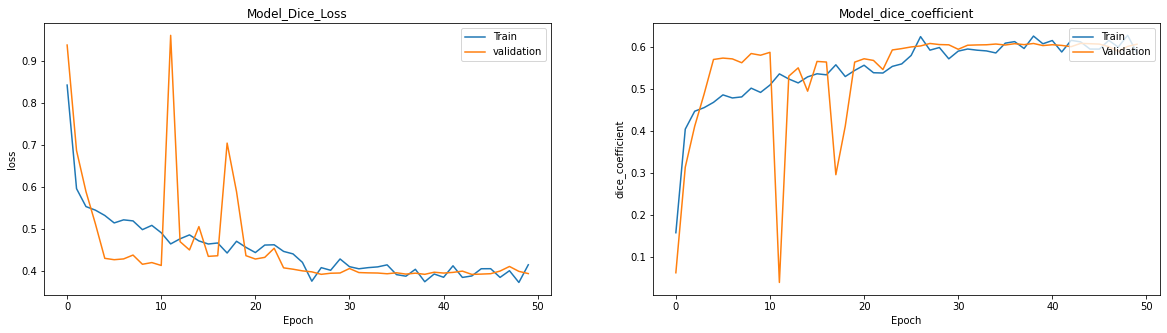

In [ ]:
# Plotting training & validation loss values for Class-1 (U-net Model with inceptionresnetv2 backbone)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_segmentation_class1.history['loss'] + history_2_segmentation_class1.history['loss'])
plt.plot(history_1_segmentation_class1.history['val_loss'] + history_2_segmentation_class1.history['val_loss'])
plt.title('Model_Dice_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_segmentation_class1.history['dice_coefficient'] + history_2_segmentation_class1.history['dice_coefficient'])
plt.plot(history_1_segmentation_class1.history['val_dice_coefficient'] + history_2_segmentation_class1.history['val_dice_coefficient'])
plt.title('Model_dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  The validation data fluctuated in first 20 epochs and then got stabilized.

2. More train data may be helpful to solve this problem.

3. The train and validation data did not vary much, so the model didn't overfit.


><font size="4" color='blue'>Model Evaluation Class_1_Images:  </font>

In [ ]:
model_6 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_6.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader_class1 = Segmentation_Train_Datagen(class_1_images_tr, batch_size=8, shuffle=True)
Validation_dataloader_class1 = Segmentation_Test_Datagen(class_1_images_cv, batch_size=1, shuffle=False)
Test_dataloader_class1 = Segmentation_Test_Datagen(class_1_images_te, batch_size=1, shuffle=False)

In [ ]:
# U-net Model scores class1
train_scores_unet_incep_res_v2 = model_6.evaluate(train_dataloader_class1,verbose=1)
cv_scores_unet_incep_res_v2 = model_6.evaluate(Validation_dataloader_class1,verbose=1)
test_Scores_unet_incep_res_v2 = model_6.evaluate(Test_dataloader_class1,verbose=1)

89/89 [==============================] - 44s 500ms/step - loss: 0.3567 - dice_coefficient: 0.6433


In [ ]:
# U-net Model_Results class1

c = pd.DataFrame([train_scores_unet_incep_res_v2,cv_scores_unet_incep_res_v2,test_Scores_unet_incep_res_v2],columns = ['loss','dice_coefficient'],index = ['Train','Cv','Test'] )
U_net_Model_Results_class1 = c.T
U_net_Model_Results_class1

,Train,Cv,Test
loss,0.371122,0.391192,0.356663
dice_coefficient,0.628878,0.608808,0.643336


><font size="4" color='blue'>Training the model for Class_2_Images:  </font>



In [ ]:
Segmentation_model.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader = Segmentation_Train_Datagen(class_2_images_tr, batch_size=8, shuffle=True)
Validation_dataloader = Segmentation_Test_Datagen(class_2_images_cv, batch_size=1, shuffle=False)

In [ ]:
model_filepath = '/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5'
model_checkpoint_seg_class2 = ModelCheckpoint(filepath = model_filepath, monitor = 'val_dice_coefficient',  verbose=1, save_best_only=True, mode='max')
tensorboard_logdir = '/content/drive/MyDrive/Case_Study_2/logs_segmentation_model_class2/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_seg_class2 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir,histogram_freq = 0)

In [ ]:
history_1_segmentation_class2 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class2,tensorboard_callback_seg_class2])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
24/24 [==============================] - 141s 5s/step - loss: 0.7541 - dice_coefficient: 0.2459 - val_loss: 0.5595 - val_dice_coefficient: 0.4405

Epoch 00001: val_dice_coefficient improved from -inf to 0.44051, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5
Epoch 2/25
24/24 [==============================] - 39s 2s/step - loss: 0.4830 - dice_coefficient: 0.5170 - val_loss: 0.4383 - val_dice_coefficient: 0.5617

Epoch 00002: val_dice_coefficient improved from 0.44051 to 0.56169, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5
Epoch 3/25
24/24 [==============================] - 39s 2s/step - loss: 0.5187 - dice_coefficient: 0.4813 - val_loss: 0.4067 - val_dice_coefficient: 0.5933

Epoch 00003: val_dice_coefficient improved from 0.56169 to 0.59331, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5
Epoch 4/25
24/24 [==============================] - 39s 2s/step - loss: 0.4155 - 

In [ ]:
history_1_segmentation_class2.history

{'dice_coefficient': [0.3312450647354126,
  0.5181819796562195,
  0.4788949489593506,
  0.573066771030426,
  0.557274580001831,
  0.5522758364677429,
  0.5780195593833923,
  0.5957913994789124,
  0.5938406586647034,
  0.5719450116157532,
  0.5831594467163086,
  0.6162610650062561,
  0.5969825387001038,
  0.5753002166748047,
  0.6340662837028503,
  0.5988478660583496,
  0.6205063462257385,
  0.62015300989151,
  0.5954905152320862,
  0.6355300545692444,
  0.6481077075004578,
  0.6327767968177795,
  0.6606972813606262,
  0.6253610849380493,
  0.6616937518119812],
 'loss': [0.6687549948692322,
  0.48181799054145813,
  0.5211050510406494,
  0.42693325877189636,
  0.44272541999816895,
  0.4477241337299347,
  0.42198047041893005,
  0.40420857071876526,
  0.406159371137619,
  0.4280550181865692,
  0.4168405532836914,
  0.38373884558677673,
  0.40301749110221863,
  0.4246997833251953,
  0.36593368649482727,
  0.40115222334861755,
  0.3794936239719391,
  0.37984704971313477,
  0.4045095443725586

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class2.h5')

In [ ]:
Segmentation_model.load_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class2.h5')

In [ ]:
K.set_value(Segmentation_model.optimizer.learning_rate, 0.0001)

In [ ]:
history_2_segmentation_class2 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class2,tensorboard_callback_seg_class2])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
24/24 [==============================] - 40s 2s/step - loss: 0.3546 - dice_coefficient: 0.6454 - val_loss: 0.3926 - val_dice_coefficient: 0.6074

Epoch 00001: val_dice_coefficient did not improve from 0.66419
Epoch 2/25
24/24 [==============================] - 39s 2s/step - loss: 0.3927 - dice_coefficient: 0.6073 - val_loss: 0.4050 - val_dice_coefficient: 0.5950

Epoch 00002: val_dice_coefficient did not improve from 0.66419
Epoch 3/25
24/24 [==============================] - 39s 2s/step - loss: 0.3608 - dice_coefficient: 0.6392 - val_loss: 0.4016 - val_dice_coefficient: 0.5984

Epoch 00003: val_dice_coefficient did not improve from 0.66419
Epoch 4/25
24/24 [==============================] - 39s 2s/step - loss: 0.3595 - dice_coefficient: 0.6405 - val_loss: 0.3869 - val_dice_coefficient: 0.6131

Epoch 00004: val_dice_coefficient did not improve from 0.66419
Epoch 5/25
24/24 [==============================] - 38s 2s/step - loss: 0.3514 - dice_coefficient: 0.6486 - val_loss: 0.

In [ ]:
history_2_segmentation_class2.history

{'dice_coefficient': [0.6454253196716309,
  0.6072681546211243,
  0.6392061710357666,
  0.6404992938041687,
  0.6486088037490845,
  0.6831031441688538,
  0.5993488430976868,
  0.6485400795936584,
  0.6713390350341797,
  0.6566701531410217,
  0.6643564105033875,
  0.6440452933311462,
  0.6964607834815979,
  0.6850821375846863,
  0.6566095948219299,
  0.6548423171043396,
  0.6774954199790955,
  0.6943991184234619,
  0.6704934239387512,
  0.6779344081878662,
  0.7110781669616699,
  0.679807186126709,
  0.7019436955451965,
  0.6868487000465393,
  0.7030840516090393],
 'loss': [0.35457468032836914,
  0.3927319347858429,
  0.360793799161911,
  0.3595006763935089,
  0.3513911962509155,
  0.31689682602882385,
  0.4006511867046356,
  0.35145998001098633,
  0.3286609947681427,
  0.34332990646362305,
  0.33564361929893494,
  0.35595473647117615,
  0.30353912711143494,
  0.31491783261299133,
  0.34339043498039246,
  0.3451577425003052,
  0.32250452041625977,
  0.3056008815765381,
  0.3295066058635

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after50epoch_class2.h5')

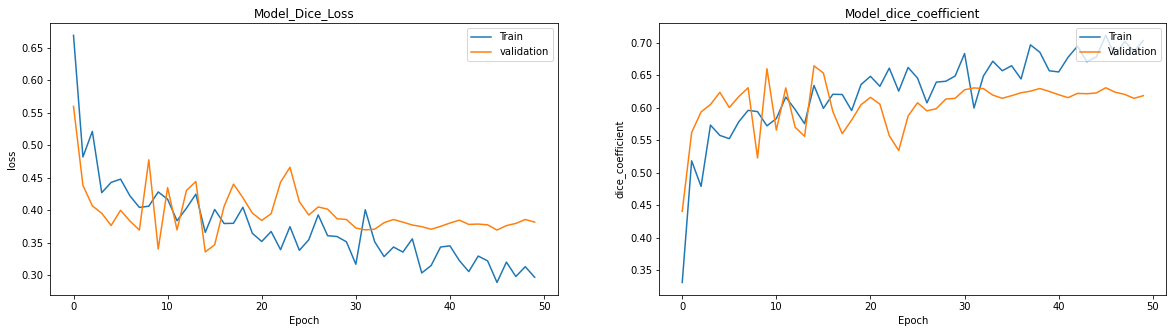

In [ ]:
# Plotting training & validation loss values for Class-2 (U-net Model with inceptionresnetv2 backbone)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_segmentation_class2.history['loss'] + history_2_segmentation_class2.history['loss'])
plt.plot(history_1_segmentation_class2.history['val_loss'] + history_2_segmentation_class2.history['val_loss'])
plt.title('Model_Dice_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_segmentation_class2.history['dice_coefficient'] + history_2_segmentation_class2.history['dice_coefficient'])
plt.plot(history_1_segmentation_class2.history['val_dice_coefficient'] + history_2_segmentation_class2.history['val_dice_coefficient'])
plt.title('Model_dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  The graph is not stable compared to the class1 defect, This may be due to the less number of images have class2 defect.

2. More train data may be helpful to solve this problem.


><font size="4" color='blue'>Model Evaluation Class_2_Images:  </font>


In [ ]:
model_7 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_7.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader_class2 = Segmentation_Train_Datagen(class_2_images_tr, batch_size=8, shuffle=True)
Validation_dataloader_class2 = Segmentation_Test_Datagen(class_2_images_cv, batch_size=1, shuffle=False)
Test_dataloader_class2 = Segmentation_Test_Datagen(class_2_images_te, batch_size=1, shuffle=False)

In [ ]:
# U-net Model scores class2

train_scores_unet_incep_res_v2 = model_7.evaluate(train_dataloader_class2,verbose=1)
cv_scores_unet_incep_res_v2 = model_7.evaluate(Validation_dataloader_class2,verbose=1)
test_Scores_unet_incep_res_v2 = model_7.evaluate(Test_dataloader_class2,verbose=1)

25/25 [==============================] - 10s 429ms/step - loss: 0.4039 - dice_coefficient: 0.5961


In [ ]:
# U-net Model_Results class2

c = pd.DataFrame([train_scores_unet_incep_res_v2,cv_scores_unet_incep_res_v2,test_Scores_unet_incep_res_v2],columns = ['loss','dice_coefficient'],index = ['Train','Cv','Test'] )
U_net_Model_Results_class2 = c.T
U_net_Model_Results_class2

,Train,Cv,Test
loss,0.38047,0.335809,0.403922
dice_coefficient,0.61953,0.664191,0.596078


><font size="4" color='blue'>Training the model for Class_3_Images:  </font>

In [ ]:
train_dataloader = Segmentation_Train_Datagen(class_3_images_tr, batch_size=8, shuffle=True)
Validation_dataloader = Segmentation_Test_Datagen(class_3_images_cv, batch_size=1, shuffle=False)

In [ ]:
model_filepath = '/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5'
model_checkpoint_seg_class3 = ModelCheckpoint(filepath = model_filepath, monitor = 'val_dice_coefficient',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir = '/content/drive/MyDrive/Case_Study_2/logs_segmentation_model_class3/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_seg_class3 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir,histogram_freq = 0)

In [ ]:
history_1_segmentation_class3 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class3,tensorboard_callback_seg_class3])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
516/516 [==============================] - 3190s 6s/step - loss: 0.5734 - dice_coefficient: 0.4266 - val_loss: 0.4127 - val_dice_coefficient: 0.5873

Epoch 00001: val_dice_coefficient improved from -inf to 0.58729, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5
Epoch 2/25
516/516 [==============================] - 831s 2s/step - loss: 0.4627 - dice_coefficient: 0.5373 - val_loss: 0.3761 - val_dice_coefficient: 0.6239

Epoch 00002: val_dice_coefficient improved from 0.58729 to 0.62393, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5
Epoch 3/25
516/516 [==============================] - 832s 2s/step - loss: 0.4610 - dice_coefficient: 0.5390 - val_loss: 0.3479 - val_dice_coefficient: 0.6521

Epoch 00003: val_dice_coefficient improved from 0.62393 to 0.65213, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5
Epoch 4/25
516/516 [==============================] - 833s 2s/step - los

In [ ]:
history_1_segmentation_class3.history

{'dice_coefficient': [0.4266,
  0.5373,
  0.539,
  0.5561,
  0.5602,
  0.5764,
  0.5989,
  0.5785,
  0.5959,
  0.5898,
  0.5909,
  0.5909,
  0.6097,
  0.6167,
  0.5948,
  0.6238,
  0.6073,
  0.6091,
  0.6102,
  0.6237,
  0.6196,
  0.6359,
  0.621],
 'loss': [0.5734,
  0.4627,
  0.461,
  0.4439,
  0.4398,
  0.4236,
  0.4011,
  0.4215,
  0.4041,
  0.4102,
  0.4091,
  0.4091,
  0.3903,
  0.3833,
  0.4052,
  0.3762,
  0.3927,
  0.3909,
  0.3898,
  0.3763,
  0.3804,
  0.3641,
  0.379],
 'val_dice_coefficient': [0.5873,
  0.6239,
  0.6521,
  0.6695,
  0.6045,
  0.602,
  0.6841,
  0.6645,
  0.6833,
  0.6414,
  0.6879,
  0.6704,
  0.6782,
  0.6893,
  0.684,
  0.6932,
  0.6655,
  0.6983,
  0.6897,
  0.6577,
  0.6941,
  0.6975,
  0.6914],
 'val_loss': [0.4127,
  0.3761,
  0.3479,
  0.3305,
  0.3955,
  0.398,
  0.3159,
  0.3355,
  0.3167,
  0.3586,
  0.3121,
  0.3296,
  0.3218,
  0.3107,
  0.316,
  0.3068,
  0.3345,
  0.3017,
  0.3103,
  0.3423,
  0.3059,
  0.3025,
  0.3086]}

In [ ]:
K.set_value(Segmentation_model.optimizer.learning_rate, 0.0001)

In [ ]:
history_2_segmentation_class3 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 10, verbose=1, callbacks = [model_checkpoint_seg_class3,tensorboard_callback_seg_class3])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
516/516 [==============================] - 1583s 3s/step - loss: 0.3739 - dice_coefficient: 0.6261 - val_loss: 0.2948 - val_dice_coefficient: 0.7052

Epoch 00001: val_dice_coefficient improved from -inf to 0.70515, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5
Epoch 2/10
516/516 [==============================] - 380s 737ms/step - loss: 0.3651 - dice_coefficient: 0.6349 - val_loss: 0.2977 - val_dice_coefficient: 0.7023

Epoch 00002: val_dice_coefficient did not improve from 0.70515
Epoch 3/10
516/516 [==============================] - 379s 735ms/step - loss: 0.3436 - dice_coefficient: 0.6564 - val_loss: 0.3026 - val_dice_coefficient: 0.6974

Epoch 00003: val_dice_coefficient did not improve from 0.70515
Epoch 4/10
516/516 [==============================] - 380s 735ms/step - loss: 0.3680 - dice_coefficient: 0.6320 - val_loss: 0.2917 - val_dice_coefficient: 0.7083

Epoch 00004: val_dice_coefficient improved from 0.70515 to 0.70830, saving mo

In [ ]:
history_2_segmentation_class3.history

{'dice_coefficient': [0.6339578032493591,
  0.637240469455719,
  0.6461002230644226,
  0.6354052424430847,
  0.6371651887893677,
  0.6498531699180603,
  0.6575214862823486,
  0.6393499970436096,
  0.6510342955589294,
  0.6574773192405701],
 'loss': [0.3660421371459961,
  0.3627597689628601,
  0.3538999557495117,
  0.36459481716156006,
  0.3628348708152771,
  0.3501465618610382,
  0.342478483915329,
  0.3606499433517456,
  0.34896576404571533,
  0.3425225615501404],
 'val_dice_coefficient': [0.7051509618759155,
  0.7022544145584106,
  0.6974475979804993,
  0.7082974910736084,
  0.7085086703300476,
  0.7044965624809265,
  0.7051892280578613,
  0.7026659846305847,
  0.7037225961685181,
  0.7072587013244629],
 'val_loss': [0.294848769903183,
  0.2977462410926819,
  0.3025524318218231,
  0.2917022109031677,
  0.2914913594722748,
  0.2955036163330078,
  0.29481104016304016,
  0.2973339259624481,
  0.2962769865989685,
  0.2927412688732147]}

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after35epoch_class3.h5')

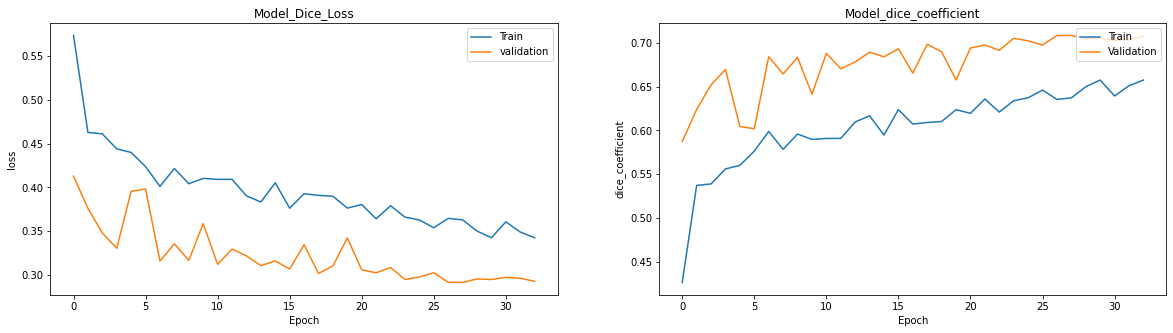

In [ ]:
# Plotting training & validation loss values for Class-3 (U-net Model with inceptionresnetv2 backbone)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_segmentation_class3.history['loss'] + history_2_segmentation_class3.history['loss'])
plt.plot(history_1_segmentation_class3.history['val_loss'] + history_2_segmentation_class3.history['val_loss'])
plt.title('Model_Dice_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_segmentation_class3.history['dice_coefficient'] + history_2_segmentation_class3.history['dice_coefficient'])
plt.plot(history_1_segmentation_class3.history['val_dice_coefficient'] + history_2_segmentation_class3.history['val_dice_coefficient'])
plt.title('Model_dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  The data is stable comapared to other class images.

2. The train and validation data varied slightly, so the model did overfit.

3. A different Segmentation model might help solve this problem.


><font size="4" color='blue'>Model Evaluation Class_3_Images:  </font>

In [ ]:
model_8 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_8.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader_class3 = Segmentation_Train_Datagen(class_3_images_tr, batch_size=8, shuffle=True)
Validation_dataloader_class3 = Segmentation_Test_Datagen(class_3_images_cv, batch_size=1, shuffle=False)
Test_dataloader_class3 = Segmentation_Test_Datagen(class_3_images_te, batch_size=1, shuffle=False)

In [ ]:
# U-net Model scores class3

train_scores_unet_incep_res_v2 = model_8.evaluate(train_dataloader_class3,verbose=1)
cv_scores_unet_incep_res_v2 = model_8.evaluate(Validation_dataloader_class3,verbose=1)
test_Scores_unet_incep_res_v2 = model_8.evaluate(Test_dataloader_class3,verbose=1)

512/512 [==============================] - 240s 469ms/step - loss: 0.2878 - dice_coefficient: 0.7122


In [ ]:
# U-net Model_Results class3

c = pd.DataFrame([train_scores_unet_incep_res_v2,cv_scores_unet_incep_res_v2,test_Scores_unet_incep_res_v2],columns = ['loss','dice_coefficient'],index = ['Train','Cv','Test'] )
U_net_Model_Results_class3 = c.T
U_net_Model_Results_class3

,Train,Cv,Test
loss,0.342067,0.291491,0.287782
dice_coefficient,0.657932,0.708509,0.712217


><font size="4" color='blue'>Training the model for Class_4_Images:  </font>




In [ ]:
Segmentation_model.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader = Segmentation_Train_Datagen(class_4_images_tr, batch_size=8, shuffle=True)
Validation_dataloader = Segmentation_Test_Datagen(class_4_images_cv, batch_size=1, shuffle=False)

In [ ]:
model_filepath = '/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5'
model_checkpoint_seg_class4 = ModelCheckpoint(filepath = model_filepath, monitor = 'val_dice_coefficient',  verbose=1, save_best_only=True, mode='max')

tensorboard_logdir = '/content/drive/MyDrive/Case_Study_2/logs_segmentation_model_class4/scalars/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_seg_class4 = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_logdir,histogram_freq = 0)

In [ ]:
history_1_segmentation_class4 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class4,tensorboard_callback_seg_class4])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
80/80 [==============================] - 189s 2s/step - loss: 0.7095 - dice_coefficient: 0.2905 - val_loss: 0.8117 - val_dice_coefficient: 0.1883

Epoch 00001: val_dice_coefficient improved from -inf to 0.18828, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5
Epoch 2/25
80/80 [==============================] - 122s 2s/step - loss: 0.4383 - dice_coefficient: 0.5617 - val_loss: 0.6006 - val_dice_coefficient: 0.3994

Epoch 00002: val_dice_coefficient improved from 0.18828 to 0.39939, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5
Epoch 3/25
80/80 [==============================] - 122s 2s/step - loss: 0.4074 - dice_coefficient: 0.5926 - val_loss: 0.2983 - val_dice_coefficient: 0.7017

Epoch 00003: val_dice_coefficient improved from 0.39939 to 0.70165, saving model to /content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5
Epoch 4/25
80/80 [==============================] - 122s 2s/step - loss: 0.4324

In [ ]:
history_1_segmentation_class4.history

{'dice_coefficient': [0.37091064453125,
  0.5539029836654663,
  0.588440477848053,
  0.5808201432228088,
  0.5769044160842896,
  0.6156765222549438,
  0.6059977412223816,
  0.5790160298347473,
  0.6092772483825684,
  0.6500061750411987,
  0.5979986786842346,
  0.6389686465263367,
  0.599554717540741,
  0.6504534482955933,
  0.6495476365089417,
  0.6229015588760376,
  0.6193053722381592,
  0.6463268995285034,
  0.6191815137863159,
  0.6392369270324707,
  0.6459304094314575,
  0.6329914331436157,
  0.6476330757141113,
  0.6335540413856506,
  0.6677861213684082],
 'loss': [0.6290891766548157,
  0.4460970461368561,
  0.4115596413612366,
  0.4191798269748688,
  0.42309561371803284,
  0.3843232989311218,
  0.39400237798690796,
  0.42098402976989746,
  0.39072278141975403,
  0.34999382495880127,
  0.4020013213157654,
  0.361031174659729,
  0.40044522285461426,
  0.3495463728904724,
  0.35045263171195984,
  0.3770986795425415,
  0.3806944787502289,
  0.3536730706691742,
  0.38081860542297363,


In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class4.h5')

In [ ]:
Segmentation_model.load_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after25epoch_class4.h5')

In [ ]:
K.set_value(Segmentation_model.optimizer.learning_rate, 0.0001)

In [ ]:
history_2_segmentation_class4 = Segmentation_model.fit_generator(train_dataloader, validation_data = Validation_dataloader, epochs = 25, verbose=1, callbacks = [model_checkpoint_seg_class4,tensorboard_callback_seg_class4])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
80/80 [==============================] - 123s 2s/step - loss: 0.3436 - dice_coefficient: 0.6564 - val_loss: 0.2977 - val_dice_coefficient: 0.7023

Epoch 00001: val_dice_coefficient did not improve from 0.74899
Epoch 2/25
80/80 [==============================] - 122s 2s/step - loss: 0.3478 - dice_coefficient: 0.6522 - val_loss: 0.3008 - val_dice_coefficient: 0.6992

Epoch 00002: val_dice_coefficient did not improve from 0.74899
Epoch 3/25
80/80 [==============================] - 122s 2s/step - loss: 0.3273 - dice_coefficient: 0.6727 - val_loss: 0.2960 - val_dice_coefficient: 0.7040

Epoch 00003: val_dice_coefficient did not improve from 0.74899
Epoch 4/25
80/80 [==============================] - 121s 2s/step - loss: 0.3070 - dice_coefficient: 0.6930 - val_loss: 0.3136 - val_dice_coefficient: 0.6864

Epoch 00004: val_dice_coefficient did not improve from 0.74899
Epoch 5/25
80/80 [==============================] - 121s 2s/step - loss: 0.3380 - dice_coefficient: 0.6620 - val_los

In [ ]:
history_2_segmentation_class4.history

{'dice_coefficient': [0.6564469337463379,
  0.6521638631820679,
  0.6726546883583069,
  0.6930298805236816,
  0.6619786620140076,
  0.6468956470489502,
  0.6766553521156311,
  0.6476589441299438,
  0.6766420602798462,
  0.6749190092086792,
  0.6625551581382751,
  0.6699751615524292,
  0.6962366700172424,
  0.6688437461853027,
  0.6623182892799377,
  0.6921917200088501,
  0.7144737839698792,
  0.7105978727340698,
  0.6809495687484741,
  0.6679969429969788,
  0.7082151770591736,
  0.7001279592514038,
  0.7044827938079834,
  0.6943691968917847,
  0.6964588761329651],
 'loss': [0.34355297684669495,
  0.34783628582954407,
  0.3273453414440155,
  0.30697011947631836,
  0.33802130818367004,
  0.35310444235801697,
  0.3233446478843689,
  0.3523411750793457,
  0.32335805892944336,
  0.3250812292098999,
  0.3374449610710144,
  0.3300246596336365,
  0.3037634789943695,
  0.33115634322166443,
  0.3376818001270294,
  0.3078082799911499,
  0.285526305437088,
  0.28940191864967346,
  0.31905046105384

In [ ]:
Segmentation_model.save_weights('/content/drive/MyDrive/Case_Study_2/seg_model_weights_after50epoch_class4.h5')

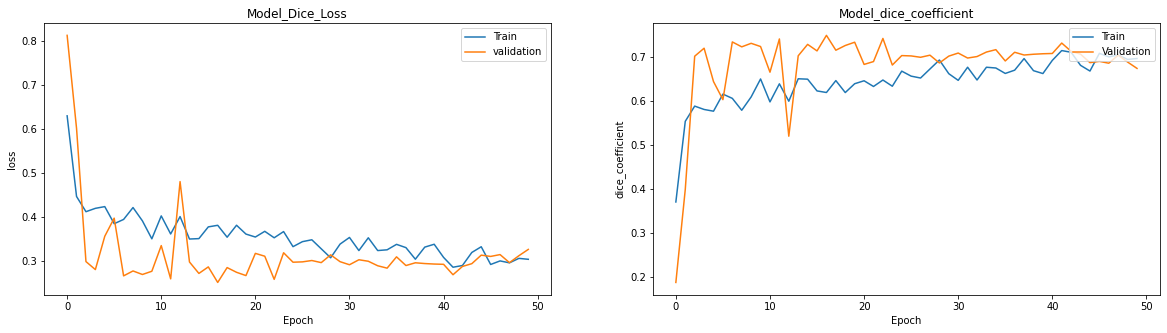

In [ ]:
# Plotting training & validation loss values for Class-4 (U-net Model with inceptionresnetv2 backbone)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history_1_segmentation_class4.history['loss'] + history_2_segmentation_class4.history['loss'])
plt.plot(history_1_segmentation_class4.history['val_loss'] + history_2_segmentation_class4.history['val_loss'])
plt.title('Model_Dice_Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation precision values
plt.subplot(122)
plt.plot(history_1_segmentation_class4.history['dice_coefficient'] + history_2_segmentation_class4.history['dice_coefficient'])
plt.plot(history_1_segmentation_class4.history['val_dice_coefficient'] + history_2_segmentation_class4.history['val_dice_coefficient'])
plt.title('Model_dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Observation:**

1.  The graph is not stable compared to the class3 defect, This may be due to the less data.

2. More train data may be helpful to solve this problem.


><font size="4" color='blue'>Model Evaluation Class_4_Images:  </font>

In [ ]:
model_9 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_9.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [ ]:
train_dataloader_class4 = Segmentation_Train_Datagen(class_4_images_tr, batch_size=8, shuffle=True)
Validation_dataloader_class4 = Segmentation_Test_Datagen(class_4_images_cv, batch_size=1, shuffle=False)
Test_dataloader_class4 = Segmentation_Test_Datagen(class_4_images_te, batch_size=1, shuffle=False)

In [ ]:
# U-net Model scores class4

train_scores_unet_incep_res_v2 = model_9.evaluate(train_dataloader_class4,verbose=1)
cv_scores_unet_incep_res_v2 = model_9.evaluate(Validation_dataloader_class4,verbose=1)
test_Scores_unet_incep_res_v2 = model_9.evaluate(Test_dataloader_class4,verbose=1)

80/80 [==============================] - 28s 350ms/step - loss: 0.2732 - dice_coefficient: 0.7268


In [ ]:
# U-net Model_Results class4

c = pd.DataFrame([train_scores_unet_incep_res_v2,cv_scores_unet_incep_res_v2,test_Scores_unet_incep_res_v2],columns = ['loss','dice_coefficient'],index = ['Train','Cv','Test'] )
U_net_Model_Results_class4 = c.T
U_net_Model_Results_class4

,Train,Cv,Test
loss,0.3696,0.251008,0.273151
dice_coefficient,0.6304,0.748992,0.726849


><font size="4" color='blue'>Some Predicted Segmentation Maps of Class_1:  </font>




In [ ]:
sample_class_1 = class_1_images_te.sample(5).reset_index(drop=True)
sample_class_1

,ID,ENCODING
0,af7c08f36.jpg,25166 7 25422 21 25678 28 25934 28 26190 28 26...
1,65f40b75f.jpg,236384 7 236630 19 236881 26 237136 30 237391 ...
2,cd0c2417f.jpg,3404 29 3660 33 3915 38 4171 40 4426 40 4682 4...
3,862bcc9c0.jpg,36160 49 36416 49 36672 49 36928 48 37184 48 3...
4,72bebf035.jpg,36937 21 37172 42 37428 42 37684 42 37940 42 3...


In [ ]:
# best-model-class1
model_6 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_6.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

# best-model-class2
model_7 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_7.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

# best-model-class3
model_8 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_8.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

# best-model-class4
model_9 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
model_9.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

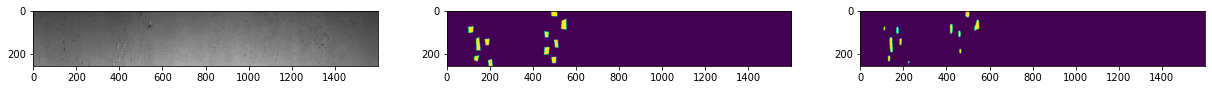

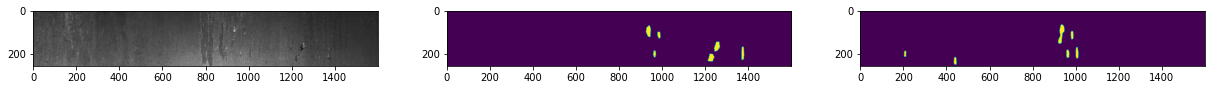

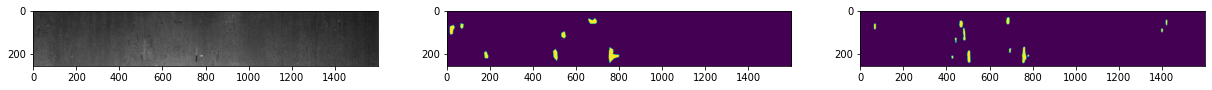

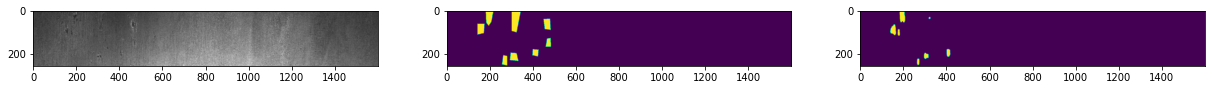

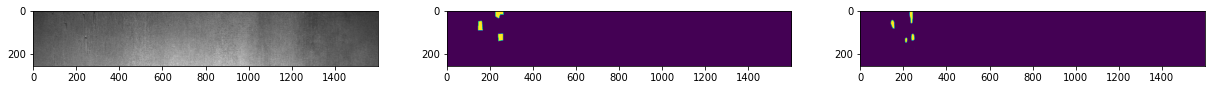

In [ ]:
for i in range(0,5):
    
    #original image
    image = cv2.imread(root_path + sample_class_1.iloc[i]['ID'])
    image = 1/255. * image

    #original segmentation map
    
    image_mask = rle2mask(sample_class_1['ENCODING'][i])

    #predicted segmentation map

    predicted  = model_6.predict(image[np.newaxis,:,:,:])
 

    plt.figure(figsize=(21,5))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0])
    
    plt.show()

><font size="4" color='blue'>Some Predicted Segmentation Maps of Class_2:  </font>




In [ ]:
sample_class_2 = class_2_images_te.sample(5).reset_index(drop=True)
sample_class_2

,ID,ENCODING
0,9b57cbc21.jpg,231068 13 231324 38 231579 64 231835 89 232091...
1,4cca18753.jpg,218369 9 218625 26 218881 43 219137 60 219393 ...
2,e56d5dfde.jpg,239900 62 240156 124 240412 124 240668 124 240...
3,3fe32ff2f.jpg,32349 79 32527 157 32783 158 33039 158 33295 1...
4,fad2dd8ee.jpg,361573 29 361772 86 361999 115 362255 115 3625...


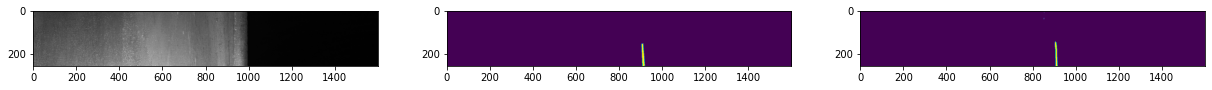

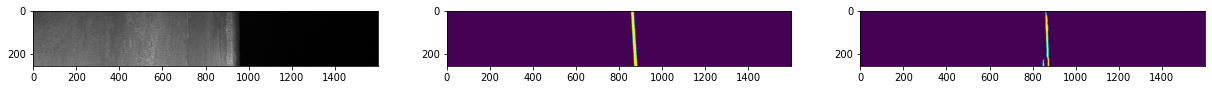

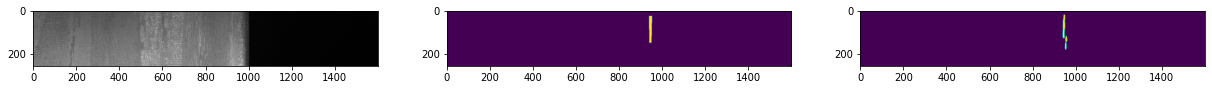

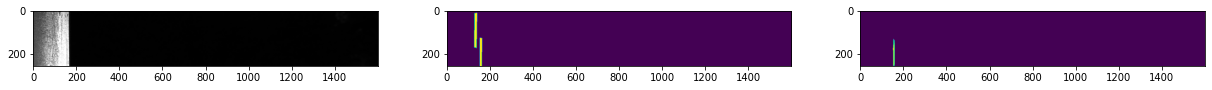

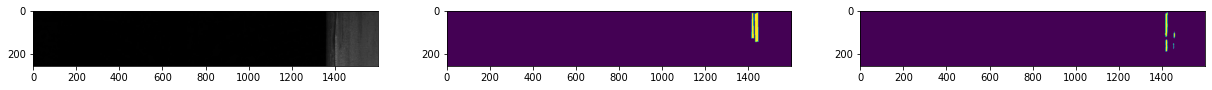

In [ ]:
for i in range(0,5):
    
    #original image
    
    image = cv2.imread(root_path + sample_class_2.iloc[i]['ID'], cv2.IMREAD_UNCHANGED)
    image = 1/255. * image

    #original segmentation map
    
    image_mask = rle2mask(sample_class_2['ENCODING'][i])
    
    #predicted segmentation map

    predicted  = model_7.predict(image[np.newaxis,:,:,:])

    plt.figure(figsize=(21,5))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0])
    
    plt.show()

><font size="4" color='blue'>Some Predicted Segmentation Maps of Class_3:  </font>




In [ ]:
sample_class_3 = class_3_images_te.sample(5).reset_index(drop=True)
sample_class_3

,ID,ENCODING
0,567578f1b.jpg,8449 5 8705 14 8961 22 9003 18 9217 62 9473 64...
1,faa80e2e8.jpg,227844 11 228100 32 228356 53 228612 74 228867...
2,180478e66.jpg,295326 3 295565 5 295580 7 295817 14 295834 12...
3,976b8a242.jpg,177921 31 178177 35 178433 39 178689 41 178945...
4,83f88d92e.jpg,189697 13 189953 37 190209 61 190465 74 190721...


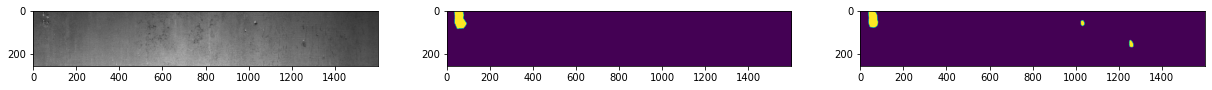

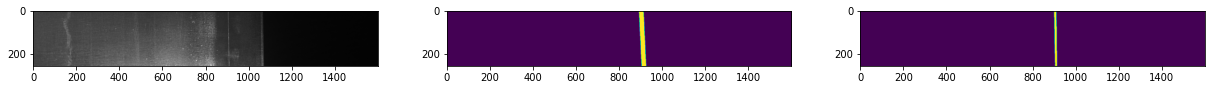

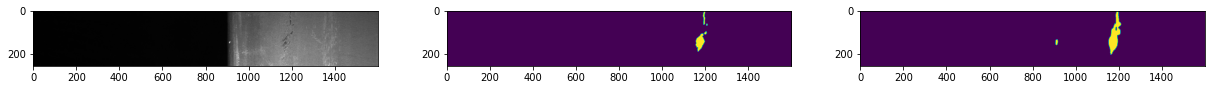

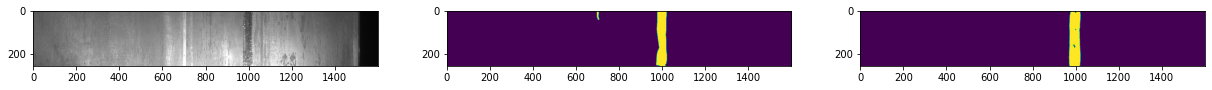

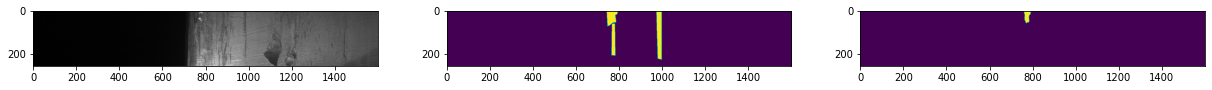

In [ ]:
for i in range(0,5):
    
    #original image
    image = cv2.imread(root_path + sample_class_3.iloc[i]['ID'], cv2.IMREAD_UNCHANGED)
    image = 1/255. * image

    #original segmentation map
    
    image_mask = rle2mask(sample_class_3['ENCODING'][i])
    
    #predicted segmentation map

    predicted  = model_8.predict(image[np.newaxis,:,:,:])

    plt.figure(figsize=(21,5))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0])
    
    plt.show()

><font size="4" color='blue'>Some Predicted Segmentation Maps of Class_4:  </font>




In [ ]:
sample_class_4 = class_4_images_te.sample(5).reset_index(drop=True)
sample_class_4

,ID,ENCODING
0,940e8cd2f.jpg,125772 3 126027 8 126281 13 126536 15 126791 1...
1,202838a14.jpg,113590 4 113844 12 114098 18 114352 22 114606 ...
2,b71ee7bd0.jpg,1720 5 1977 14 2234 23 2491 42 2748 56 3004 56...
3,685b767f1.jpg,101093 2 101348 6 101602 11 101857 14 102112 1...
4,b045a0df2.jpg,291646 10 291902 12 292158 14 292414 18 292670...


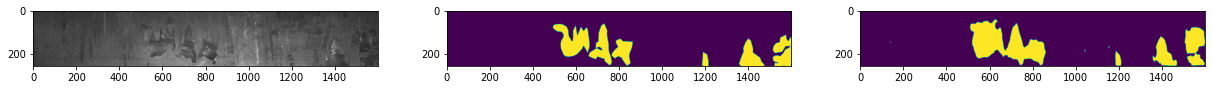

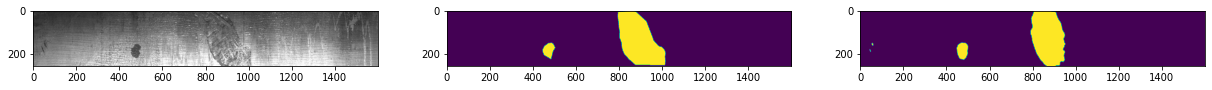

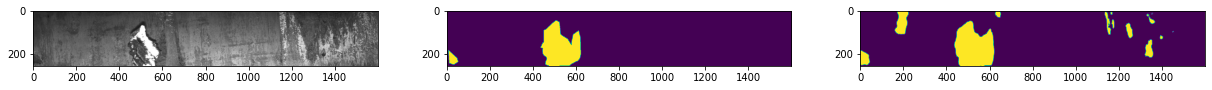

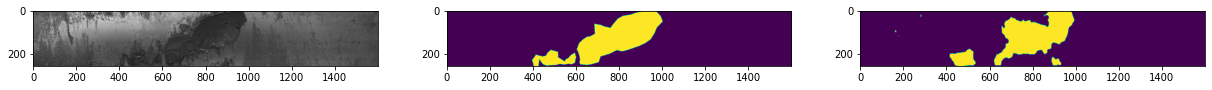

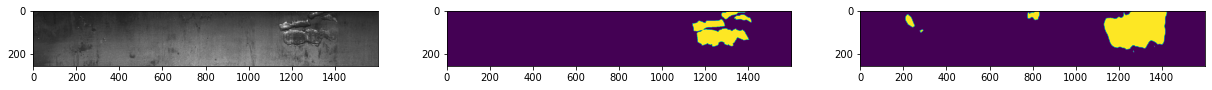

In [ ]:
for i in range(0,5):
    
    #original image
    
    image = cv2.imread(root_path + sample_class_4.iloc[i]['ID'], cv2.IMREAD_UNCHANGED)
    image = 1/255. * image

    #original segmentation map
    
    image_mask = rle2mask(sample_class_4['ENCODING'][i])
    
    #predicted segmentation map

    predicted  = model_9.predict(image[np.newaxis,:,:,:])

    plt.figure(figsize=(21,5))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0])
    
    plt.show()

**OBSERVATIONS:**

1. All the models Performed well in predicting the segmented image maps.

2. Class 3 and 4 have good number of images for training and they performed better than the other two models.

3. The dice coefficient should be improved further in class_1, by training the model for more epochs.

# Test Data Evaluation:



In [60]:
root_path_test = '/content/drive/MyDrive/Case_Study_2/test_images/'
Test_image_names = []
for i in os.listdir(root_path_test):
    Test_image_names.append(i)
len(Test_image_names)

5506

In [10]:
# !pip install git+https://github.com/qubvel/segmentation_models
# !pip install keras==2.3.1
# from efficientnet.tfkeras import EfficientNetB4

In [13]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [15]:
# Loading All Best Models

Best_Model_Binary = load_model('/content/drive/My Drive/Case_Study_2/Binary_models/Binary_model_Xception.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
Best_Model_Binary.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

Best_Model_Multi_Label = load_model('/content/drive/My Drive/Case_Study_2/Multi_Label_models/Multi_Label_model_InceptionResNetV2.h5',custom_objects = {'recall':recall,'precision':precision,'f1_score':f1_score})
Best_Model_Multi_Label.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',precision,recall,f1_score])

Best_Model_Segmentaion_C1 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class1.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
Best_Model_Segmentaion_C1.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

Best_Model_Segmentaion_C2 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class2.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
Best_Model_Segmentaion_C2.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

Best_Model_Segmentaion_C3 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class3.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
Best_Model_Segmentaion_C3.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

Best_Model_Segmentaion_C4 = load_model('/content/drive/MyDrive/Case_Study_2/Segmentation_models/Class4.h5',custom_objects = {'dice_coefficient':dice_coefficient,'dice_loss':sm.losses.dice_loss})
Best_Model_Segmentaion_C4.compile(optimizer='adam', loss = sm.losses.dice_loss, metrics=[dice_coefficient])

In [18]:
dataframe_test = pd.DataFrame(Test_image_names,columns=['Id'])
dataframe_test['RLE'] = np.NaN
dataframe_test.head()

,Id,RLE
0,db72ffc2e.jpg,NaN
1,d221d2a3f.jpg,NaN
2,d20453181.jpg,NaN
3,d670249ed.jpg,NaN
4,d5e8bbe9a.jpg,NaN


In [21]:
# reference: https://www.kaggle.com/stainsby/fast-tested-rle

def rle_encode(img):
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [52]:
# Forming The final submission file

Idlist = []
Encodelist = []
Classlist = []

for i in tqdm(range(len(dataframe_test))):
  
  # Binary & Multi Label model
  
  image = cv2.imread(root_path_test + dataframe_test['Id'][i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (299,299), interpolation=cv2.INTER_NEAREST)
  image = (1/255.)*image

  if Best_Model_Binary.predict(image[np.newaxis,:,:,:])[0][0] > 0.9:
    class_probs = Best_Model_Multi_Label.predict(image[np.newaxis,:,:,:])[0]
    image = cv2.imread(root_path_test + dataframe_test['Id'][i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,800), interpolation=cv2.INTER_NEAREST)
    image = (1/255.)*image
    
    if class_probs[0] > 0.5:
      predicted  = Best_Model_Segmentaion_C1.predict(image[np.newaxis,:,:,:])
      predicted = predicted[0,:,:,0]
      d = Image.fromarray(predicted>=0.5)
      e = d.resize((256,1600))
      f = np.array(e).astype(np.int64)
      rle = rle_encode(f)
      Idlist.append(dataframe_test['Id'][i])
      Encodelist.append(rle)
      Classlist.append(1)
    
    if class_probs[1] > 0.5:
      predicted  = Best_Model_Segmentaion_C2.predict(image[np.newaxis,:,:,:])
      predicted = predicted[0,:,:,0]
      d = Image.fromarray(predicted>=0.5)
      e = d.resize((256,1600))
      f = np.array(e).astype(np.int64)
      rle = rle_encode(f)
      Idlist.append(dataframe_test['Id'][i])
      Encodelist.append(rle)
      Classlist.append(2)
    
    if class_probs[2] > 0.5:
      predicted  = Best_Model_Segmentaion_C3.predict(image[np.newaxis,:,:,:])
      predicted = predicted[0,:,:,0]
      d = Image.fromarray(predicted>=0.5)
      e = d.resize((256,1600))
      f = np.array(e).astype(np.int64)
      rle = rle_encode(f)
      Idlist.append(dataframe_test['Id'][i])
      Encodelist.append(rle)
      Classlist.append(3)
    
    if class_probs[3] > 0.5:
      predicted  = Best_Model_Segmentaion_C4.predict(image[np.newaxis,:,:,:])
      predicted = predicted[0,:,:,0]
      d = Image.fromarray(predicted>=0.5)
      e = d.resize((256,1600))
      f = np.array(e).astype(np.int64)
      rle = rle_encode(f)
      Idlist.append(dataframe_test['Id'][i])
      Encodelist.append(rle)
      Classlist.append(4)
    
    elif (class_probs[0]<=0.5) and (class_probs[1]<=0.5) and (class_probs[2]<=0.5) and (class_probs[3]<=0.5):
      class_ = np.argmax(class_probs) + 1

      if class_ == 1:
        predicted  = Best_Model_Segmentaion_C1.predict(image[np.newaxis,:,:,:])
        predicted = predicted[0,:,:,0]
        d = Image.fromarray(predicted>=0.5)
        e = d.resize((256,1600))
        f = np.array(e).astype(np.int64)
        rle = rle_encode(f)
        Idlist.append(dataframe_test['Id'][i])
        Encodelist.append(rle)
        Classlist.append(1)
      elif class_==2:
        predicted  = Best_Model_Segmentaion_C2.predict(image[np.newaxis,:,:,:])
        predicted = predicted[0,:,:,0]
        d = Image.fromarray(predicted>=0.5)
        e = d.resize((256,1600))
        f = np.array(e).astype(np.int64)
        rle = rle_encode(f)
        Idlist.append(dataframe_test['Id'][i])
        Encodelist.append(rle)
        Classlist.append(2)
      elif class_==3:
        predicted  = Best_Model_Segmentaion_C3.predict(image[np.newaxis,:,:,:])
        predicted = predicted[0,:,:,0]
        d = Image.fromarray(predicted>=0.5)
        e = d.resize((256,1600))
        f = np.array(e).astype(np.int64)
        rle = rle_encode(f)
        Idlist.append(dataframe_test['Id'][i])
        Encodelist.append(rle)
        Classlist.append(3) 
      elif class_==4:
        predicted  = Best_Model_Segmentaion_C4.predict(image[np.newaxis,:,:,:])
        predicted = predicted[0,:,:,0]
        d = Image.fromarray(predicted>=0.5)
        e = d.resize((256,1600))
        f = np.array(e).astype(np.int64)
        rle = rle_encode(f)
        Idlist.append(dataframe_test['Id'][i])
        Encodelist.append(rle)
        Classlist.append(4)
    
  else:
      Idlist.append(dataframe_test['Id'][i])
      Encodelist.append(np.NaN)
      Classlist.append(0)

Results = pd.DataFrame(Idlist,columns=['ImageId'])
Results['EncodedPixels'] = Encodelist
Results['ClassId'] = Classlist
Results.to_csv("/content/drive/MyDrive/Case_Study_2/Kaggle_submission",index=False)

100%|██████████| 5506/5506 [15:42<00:00,  5.84it/s]


In [59]:
Results.head()

,ImageId,EncodedPixels,ClassId
0,db72ffc2e.jpg,636 7 892 7 1146 10 1402 10 1647 3 1658 10 190...,3
1,d221d2a3f.jpg,NaN,0
2,d20453181.jpg,NaN,0
3,d670249ed.jpg,48 12 152 7 304 12 408 7 557 18 663 10 813 18 ...,3
4,d5e8bbe9a.jpg,,4
